# 레츠기리리리이이ㅣ이이잇

In [1]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# card 데이터 로드
card = pd.read_csv("CARD_SPENDING_RESIDENT.txt", sep="\t")

card_dong = pd.read_excel("card_instruct.xlsx", sheet_name=1, header=1).drop('Unnamed: 0', axis=1)

card = card.merge(card_dong, how='left', left_on = ['GU_CD', 'DONG_CD'], right_on = ['구코드', '행정동코드'])

In [3]:
# sk 유동인구 파일 로드
os.chdir('./sk')
files_sk = os.listdir()

sk = pd.DataFrame()

for file in files_sk[:8]:
    temp = pd.read_csv(file, sep="|")
    
    sk = sk.append(temp)

In [4]:
# cj 물류 파일 로드
os.chdir("../cj")

cj = pd.read_excel('cj_data.xlsx')

In [5]:
# cj 데이터의 시/군/구 정보 추출
dong_info  = cj[['CTPV_NM', 'CTGG_NM', 'HDNG_NM']].drop_duplicates()

년도/월/일 주차별 정보로 나누기 위해서 date_table과 합성

In [6]:
os.chdir('C:\\Users\\mo223\\Desktop\\big contest\\big_con_data')
date_table = pd.read_csv("date_table.csv")

In [7]:
card

,STD_DD,GU_CD,DONG_CD,MCT_CAT_CD,SEX_CD,AGE_CD,USE_CNT,USE_AMT,구코드,행정동코드,구명,행정동명
0,20190201,110,517,10,F,25,11,595,110,517,대구 중구,동인동
1,20190201,110,517,10,F,50,5,243,110,517,대구 중구,동인동
2,20190201,110,517,10,F,55,5,27,110,517,대구 중구,동인동
3,20190201,110,517,10,M,20,11,243,110,517,대구 중구,동인동
4,20190201,110,517,10,M,25,11,433,110,517,대구 중구,동인동
...,...,...,...,...,...,...,...,...,...,...,...,...
2537748,20200531,350,720,81,M,45,19,127,350,720,서울 노원구,상계10동
2537749,20200531,350,720,81,M,50,33,211,350,720,서울 노원구,상계10동
2537750,20200531,350,720,81,M,55,9,61,350,720,서울 노원구,상계10동
2537751,20200531,350,720,81,M,60,19,194,350,720,서울 노원구,상계10동


In [8]:
# card 데이터 & date_table & dong_info 테이블 합성
card = card.merge(date_table, how='left', on='STD_DD')
card = card.merge(dong_info, how='left', left_on = '행정동명', right_on = 'HDNG_NM')
card.drop(['STD_DD','구명', '행정동명'], axis=1, inplace=True)

# sk 데이터 & date_table & dong_info 테이블 합성
sk = sk.merge(date_table, how='left', left_on = 'STD_YMD', right_on = 'STD_DD')
sk = sk.merge(dong_info, how='left', left_on = 'HDONG_NM', right_on = 'HDNG_NM')
sk.drop(['STD_YM', 'STD_YMD', 'HDONG_NM'], axis=1, inplace = True)

In [9]:
# cj 데이터 일자 양식맞추기
cj['DL_YMD'] = cj['DL_YMD'] + 20000000

# cj 데이터 년 / 월 / 일 / 주차 / 요일 합치기
cj = cj.merge(date_table, how='left', left_on = 'DL_YMD', right_on = 'STD_DD')

# 카드매출데이터를 바탕으로 구간 설정

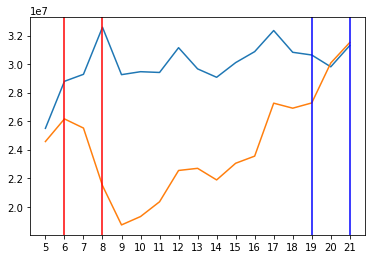

In [10]:
# 사용할 데이터만 추려내기
card_sep = card[['year','month', 'day','week_num','USE_AMT', 'USE_CNT']]

# 2019년, 2020년 카드 데이터 나누기
card_sep_2019 = card_sep[card_sep['year'] == 2019]
card_sep_2020 = card_sep[card_sep['year'] == 2020]

# 월/일/주차를 기준으로 카드 매출의 합산량을 구함.
card_sep_2019_group = card_sep_2019.pivot_table(index = ['month', 'day', 'week_num'], values='USE_AMT', aggfunc='sum').reset_index()
card_sep_2020_group = card_sep_2020.pivot_table(index = ['month', 'day', 'week_num'], values='USE_AMT', aggfunc='sum').reset_index()

# 각 일별 카드 매출의 3일 이동평균값을 계산
# why? 주차별로 비교하기 위해 토-일 전체의 데이터가 없는 
# 2019년 4주차, 2020년 4, 22주차의 데이터를 걸러내기 위함
card_sep_2019_group['rolling'] = card_sep_2019_group['USE_AMT'].rolling(window=3).mean()
card_sep_2020_group['rolling'] = card_sep_2020_group['USE_AMT'].rolling(window=3).mean()

# 주차별 이동평균 값의 평균값 산출
card_sep_2019_week = card_sep_2019_group.groupby("week_num")['rolling'].mean()
card_sep_2020_week = card_sep_2020_group.groupby("week_num")['rolling'].mean()

# 그래프 그리기
plt.plot(card_sep_2019_week[1:])
plt.plot(card_sep_2020_week[1:-1])

plt.xticks(range(5,22))
plt.axvline(x=6, color='red')
plt.axvline(x=8, color='red')

plt.axvline(x=19, color='blue')
plt.axvline(x=21, color='blue')

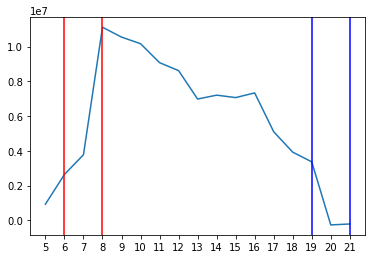

In [11]:
plt.plot(card_sep_2019_week[1:] - card_sep_2020_week[1:-1])
plt.xticks(range(5,22))
# 매출이 확 줄어드는 시기
# 이후 점점 회복세
plt.axvline(x=6, color='red')
plt.axvline(x=8, color='red')

# 매출이 급증하며 기본 카드매출을 따라잡는 구간
# 새로운 경제의 트랜드를 나타내는 시기가 아닐까 싶음
plt.axvline(x=19, color='blue')
plt.axvline(x=21, color='blue')

이를 근거로 카드 매출이 급감한 6-8주차 -> 소비 위축

9주차 부터 점점 소비활동이 정상 범주로 돌아오고 있음

변화의 기울기로 볼때 19-21주차에 소비가 안정되고 기존 카드 매출액을 따라 잡으며
새로운 소비형태를 보여줄 수 있는 시기라고 생각

## 방향성 : 6-8 주차의 유동인구 & 물류의 변화율을 바탕으로 특징별 집단을 나눈 뒤, 새로운 소비 트랜드가 부상했다고 생각하는 19-21주차의 집단별 각 년도의 매출 데이터를 분석하면 뉴노멀 트랜드를 잡을 수 있지 않을까 싶음

19년도(19년 6-8 각 주차 평균 = 100p) 대비 2020년 6-8주차의 유동인구 상대 크기를 나타내는 "유동 지수"

(유동인구의 감소가 일반적인 현상일 수 있기때문에 이를 보정해주고자 함)

In [12]:
# 일 ~ 토를 한 주 기준으로 보고 총 주차 데이터가 부족한 2019년 4주, 2020년 4주, 22주는 분석에서 제외
# 2019년 4주 인덱스 추출
week_index_201904 = sk[(sk['year'] == 2019) & (sk['week_num'] == 4)].index.tolist()
# 2020년 4주 인덱스 추출
week_index_202004 = sk[(sk['year'] == 2020) & (sk['week_num'] == 4)].index.tolist()
# 2020년 22주 인덱스 추출
week_index_202022 = sk[(sk['year'] == 2020) & (sk['week_num'] == 22)].index.tolist()

remove_index = week_index_201904 + week_index_202004 + week_index_202022

# 전체 데이터에서 제거
sk = sk.drop(remove_index,axis=0).reset_index(drop=True)

In [13]:
sk.shape

(16353, 41)

In [14]:
# 유동인구를 나타내는 칼럼들
num_columns = ['MAN_FLOW_POP_CNT_0004',
       'MAN_FLOW_POP_CNT_0509', 'MAN_FLOW_POP_CNT_1014',
       'MAN_FLOW_POP_CNT_1519', 'MAN_FLOW_POP_CNT_2024',
       'MAN_FLOW_POP_CNT_2529', 'MAN_FLOW_POP_CNT_3034',
       'MAN_FLOW_POP_CNT_3539', 'MAN_FLOW_POP_CNT_4044',
       'MAN_FLOW_POP_CNT_4549', 'MAN_FLOW_POP_CNT_5054',
       'MAN_FLOW_POP_CNT_5559', 'MAN_FLOW_POP_CNT_6064',
       'MAN_FLOW_POP_CNT_6569', 'MAN_FLOW_POP_CNT_70U',
       'WMAN_FLOW_POP_CNT_0004', 'WMAN_FLOW_POP_CNT_0509',
       'WMAN_FLOW_POP_CNT_1014', 'WMAN_FLOW_POP_CNT_1519',
       'WMAN_FLOW_POP_CNT_2024', 'WMAN_FLOW_POP_CNT_2529',
       'WMAN_FLOW_POP_CNT_3034', 'WMAN_FLOW_POP_CNT_3539',
       'WMAN_FLOW_POP_CNT_4044', 'WMAN_FLOW_POP_CNT_4549',
       'WMAN_FLOW_POP_CNT_5054', 'WMAN_FLOW_POP_CNT_5559',
       'WMAN_FLOW_POP_CNT_6064', 'WMAN_FLOW_POP_CNT_6569',
       'WMAN_FLOW_POP_CNT_70U']

In [15]:
# 유동인구의 합 계산
sk['sum_flow'] = sk[num_columns].sum(axis=1)

In [16]:
# 서울 / 대구 분리
sk_seoul = sk[sk['CTPV_NM'] == '서울특별시']
sk_daegu = sk[sk['CTPV_NM'] == '대구광역시']

# 각 지역 2019, 2020년 분리
sk_seoul_2019 = sk_seoul[sk_seoul['year'] == 2019]
sk_seoul_2020 = sk_seoul[sk_seoul['year'] == 2020]
sk_daegu_2019 = sk_daegu[sk_daegu['year'] == 2019]
sk_daegu_2020 = sk_daegu[sk_daegu['year'] == 2020]

# 기존 가설대로 6-8 주차의 유동인구 데이터 분석을 위해 테이블 분리
sk_seoul_2019_sep = sk_seoul_2019[sk_seoul_2019['week_num'].isin(range(6,9))]
sk_seoul_2020_sep = sk_seoul_2020[sk_seoul_2020['week_num'].isin(range(6,9))]
sk_daegu_2019_sep = sk_daegu_2019[sk_daegu_2019['week_num'].isin(range(6,9))]
sk_daegu_2020_sep = sk_daegu_2020[sk_daegu_2020['week_num'].isin(range(6,9))]

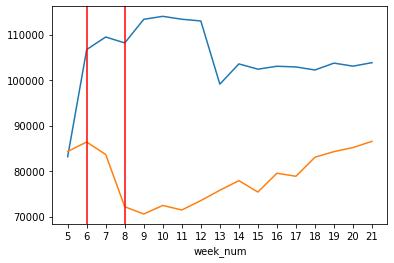

In [17]:
sk_seoul_2019.groupby("week_num")['sum_flow'].mean().plot()
sk_seoul_2020.groupby("week_num")['sum_flow'].mean().plot()
plt.xticks(range(5,22))
plt.axvline(x=6, color='red')
plt.axvline(x=8, color='red')

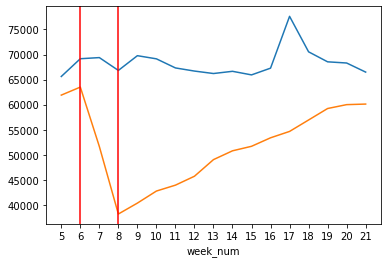

In [18]:
sk_daegu_2019.groupby("week_num")['sum_flow'].mean().plot()
sk_daegu_2020.groupby("week_num")['sum_flow'].mean().plot()
plt.xticks(range(5,22))
plt.axvline(x=6, color='red')
plt.axvline(x=8, color='red')

In [19]:
# 서울의 6-8주차 유동인구 변화지수
(sk_seoul_2020_sep['sum_flow'].mean() * 100) / sk_seoul_2019_sep['sum_flow'].mean()

74.68449978696867

In [20]:
# 대구의 6-8주차 유동인구 변화지수
(sk_daegu_2020_sep['sum_flow'].mean() * 100) / sk_daegu_2019_sep['sum_flow'].mean()

74.6947302411632

??? 왜 비슷하지..

서울이랑 대구 퉁쳐서 해보기

In [21]:
# 19년 20년 퉁치기
sk_2019 = sk[sk['year'] == 2019]
sk_2020 = sk[sk['year'] == 2020]

sk_2019_sep = sk_2019[sk_2019['week_num'].isin(range(6, 9))]
sk_2020_sep = sk_2020[sk_2020['week_num'].isin(range(6, 9))]

In [22]:
(sk_2020_sep['sum_flow'].mean() * 100) / sk_2019_sep['sum_flow'].mean()

74.63873755290457

### -> 이로 미루어보아 6-8주차의 서울 / 대구의 유동인구 감소율은 비슷!

# 구별로 한번 보자

In [23]:
from matplotlib import font_manager, rc
import platform 

# 한글 폰트 사용
if platform.system() == 'Windows': 
    path = 'c:/Windows/Fonts/malgun.ttf'
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
elif platform.system() == 'Darwin':
    rc('font', family='AppleGothic')

In [24]:
sk_seoul_gu_sep = sk_seoul_2019_sep.pivot_table(index=['CTGG_NM', 'week_num'], values='sum_flow', aggfunc='mean')

sk_seoul_gu_sep.columns =['sum_flow_2019']
sk_seoul_gu_sep['sum_flow_2020'] = sk_seoul_2020_sep.pivot_table(index=['CTGG_NM', 'week_num'], values='sum_flow', aggfunc='mean')['sum_flow']

sk_seoul_gu_sep.reset_index(inplace= True)

([<matplotlib.axis.XTick at 0x1733b5cbaf0>,
 <a list of 3 Text major ticklabel objects>)

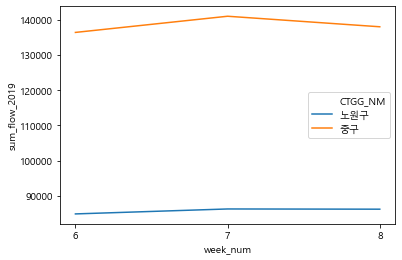

In [25]:
sns.lineplot(x='week_num', y = 'sum_flow_2019',hue='CTGG_NM', data = sk_seoul_gu_sep)
plt.xticks(range(6,9))


([<matplotlib.axis.XTick at 0x17350b89160>,
 <a list of 3 Text major ticklabel objects>)

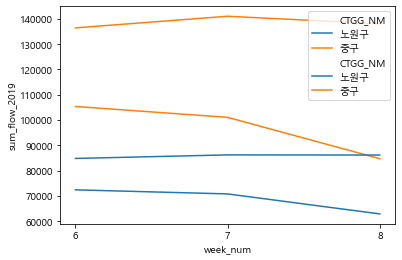

In [26]:
sns.lineplot(x='week_num', y = 'sum_flow_2020',hue='CTGG_NM', data = sk_seoul_gu_sep)
sns.lineplot(x='week_num', y = 'sum_flow_2019',hue='CTGG_NM', data = sk_seoul_gu_sep)
plt.xticks(range(6,9))

In [27]:
sk_seoul_gu_gap = sk_seoul_gu_sep.groupby("CTGG_NM")[['sum_flow_2019', 'sum_flow_2020']].mean()
sk_seoul_gu_gap['decrease_ratio'] = (sk_seoul_gu_gap['sum_flow_2020'] * 100) / sk_seoul_gu_gap['sum_flow_2019']
sk_seoul_gu_gap

,sum_flow_2019,sum_flow_2020,decrease_ratio
CTGG_NM,,,
노원구,85775.745113,68750.691003,80.151669
중구,138501.051122,97074.489252,70.089352


## 노원구에 비해 중구가 확실히 더 많이 줄어든 모습

유동인구량의 감소율의 총 량 : 74.63873755290457 인데 비해

노원구는 줄긴했으나 총 변동률 대비 별로 안줄어들었고, 중구는 총 변동률보다 많이 줄어든 모습이다.

-> 유동인구의 타격은 중구 > 노원구

# 이제 행정동별로 봐보자잉

In [28]:
sk_seoul_dong_sep = sk_seoul_2019_sep.pivot_table(index=['CTGG_NM','HDNG_NM', 'week_num'], values='sum_flow', aggfunc='mean')
sk_seoul_dong_sep.columns = ['sum_flow_2019']

sk_seoul_dong_sep['sum_flow_2020'] = sk_seoul_2020_sep.pivot_table(index=['CTGG_NM','HDNG_NM', 'week_num'], values='sum_flow', aggfunc='mean')['sum_flow']

sk_seoul_dong_sep.reset_index(inplace=True)

sk_seoul_dong_sep

,CTGG_NM,HDNG_NM,week_num,sum_flow_2019,sum_flow_2020
0,노원구,공릉1동,6,179784.165714,152344.520000
1,노원구,공릉1동,7,186025.681429,150330.804286
2,노원구,공릉1동,8,182620.527143,133488.055714
3,노원구,공릉2동,6,179784.255714,144128.342857
4,노원구,공릉2동,7,186380.051429,138100.390000
...,...,...,...,...,...
94,중구,황학동,7,61651.688571,46507.368571
95,중구,황학동,8,59691.877143,39754.077143
96,중구,회현동,6,298196.142857,214527.222857
97,중구,회현동,7,309076.871429,207760.317143


In [29]:
sk_seoul_dong_gap = sk_seoul_dong_sep.pivot_table(index=['CTGG_NM', 'HDNG_NM'], values = ['sum_flow_2019', 'sum_flow_2020'], aggfunc='mean')

In [30]:
sk_seoul_dong_gap

sum_flow_2019  sum_flow_2020
CTGG_NM HDNG_NM                              
노원구     공릉1동     182810.124762  145387.793333
        공릉2동     185402.480000  135997.191905
        상계10동     45834.933810   31229.415238
        상계1동     121682.144286   95958.085714
        상계2동      92451.611429   78200.755714
        상계3.4동    56991.224762   56901.739524
        상계5동      36772.927619   36670.709524
        상계6.7동   193706.615238  161173.056667
        상계8동      57987.020476   60967.498571
        상계9동      32552.804286   24799.473810
        월계1동      81263.702381   58264.854286
        월계2동      46319.084762   40727.066190
        월계3동     106550.123333   88937.860000
        중계1동      47172.517619   33068.091429
        중계2.3동    95169.515238   66225.518095
        중계4동      44514.861905   33794.518571
        중계본동      42765.945714   45007.916667
        하계1동      82880.441905   56961.506190
        하계2동      76911.077619   55990.077619
중구      광희동      248183.823810  171288.037143
        다산동       59170.331905   64105.176667
        동화동       20345.310000   27025.931905
        명동       363992.142857  205717.500476
        소공동      233756.829524  163068.117143
        신당동      106284.649524   92490.442857
        약수동       77327.932381   73475.292381
        을지로동     157774.176190  110530.464762
        장충동       88238.750000   54182.652857
        중림동       48277.195238   35006.270000
        청구동       31817.622857   22033.178095
        필동       136870.747143   99860.393333
        황학동       60512.447143   44847.050952
        회현동      306462.757143  195412.340952

In [31]:
sk_seoul_dong_gap['decrease_ratio'] = (sk_seoul_dong_gap['sum_flow_2020'] * 100) / sk_seoul_dong_gap['sum_flow_2019']
sk_seoul_dong_gap

sum_flow_2019  sum_flow_2020  decrease_ratio
CTGG_NM HDNG_NM                                              
노원구     공릉1동     182810.124762  145387.793333       79.529399
        공릉2동     185402.480000  135997.191905       73.352412
        상계10동     45834.933810   31229.415238       68.134527
        상계1동     121682.144286   95958.085714       78.859627
        상계2동      92451.611429   78200.755714       84.585606
        상계3.4동    56991.224762   56901.739524       99.842984
        상계5동      36772.927619   36670.709524       99.722029
        상계6.7동   193706.615238  161173.056667       83.204725
        상계8동      57987.020476   60967.498571      105.139906
        상계9동      32552.804286   24799.473810       76.182296
        월계1동      81263.702381   58264.854286       71.698498
        월계2동      46319.084762   40727.066190       87.927182
        월계3동     106550.123333   88937.860000       83.470443
        중계1동      47172.517619   33068.091429       70.100332
        중계2.3동    95169.515238   66225.518095       69.586903
        중계4동      44514.861905   33794.518571       75.917384
        중계본동      42765.945714   45007.916667      105.242421
        하계1동      82880.441905   56961.506190       68.727320
        하계2동      76911.077619   55990.077619       72.798457
중구      광희동      248183.823810  171288.037143       69.016600
        다산동       59170.331905   64105.176667      108.340066
        동화동       20345.310000   27025.931905      132.836177
        명동       363992.142857  205717.500476       56.517017
        소공동      233756.829524  163068.117143       69.759723
        신당동      106284.649524   92490.442857       87.021450
        약수동       77327.932381   73475.292381       95.017790
        을지로동     157774.176190  110530.464762       70.056119
        장충동       88238.750000   54182.652857       61.404602
        중림동       48277.195238   35006.270000       72.510985
        청구동       31817.622857   22033.178095       69.248348
        필동       136870.747143   99860.393333       72.959632
        황학동       60512.447143   44847.050952       74.112109
        회현동      306462.757143  195412.340952       63.763814

# 노원구부터 시각화

### 시각화 함수

In [63]:
def plot_region_dong_sensitivity(df, x_axis, gu_name, rot_x = True, show_xlabel = True):
    plt.figure(figsize=(18, 6))
    
    pal = sns.color_palette("Blues_r", df.shape[0])
    
    top_down_index = df['decrease_ratio'].sort_values(ascending=False).index
    plot_order = df.iloc[top_down_index]['HDNG_NM'].values
    sns.barplot(x = x_axis, y='decrease_ratio', data=df, order=plot_order)
    plt.axhline(sk_seoul_gu_gap.loc[gu_name, 'decrease_ratio'])
    df = df.sort_values(by="decrease_ratio", ascending=False)
    df['decrease_ratio'] = np.round(df['decrease_ratio'],2)
    for idx, score in enumerate(df['decrease_ratio']):
        plt.text(idx-0.4, score+0.01, score, size=13, weight='bold')

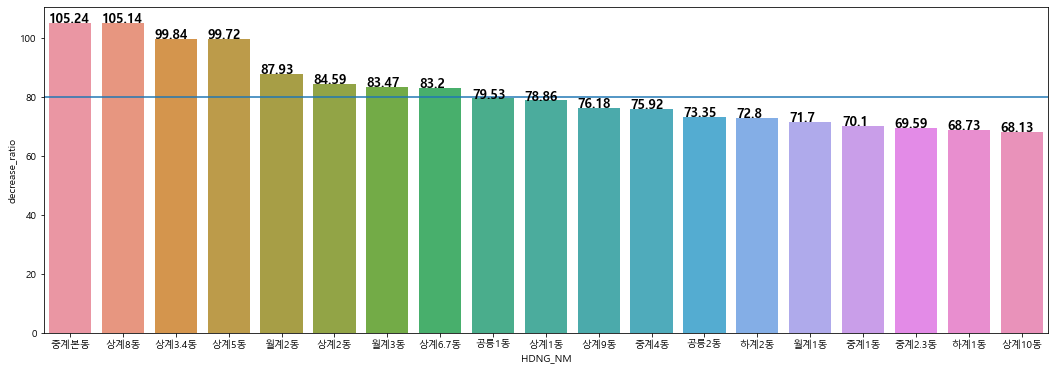

In [33]:
plot_region_dong_sensitivity(sk_seoul_dong_gap.xs("노원구").reset_index(), 'HDNG_NM', '노원구')

# 중구

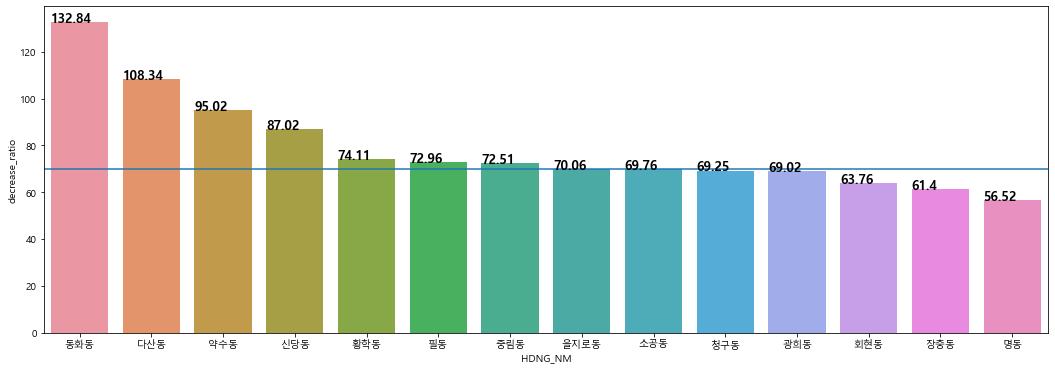

In [34]:
plot_region_dong_sensitivity(sk_seoul_dong_gap.xs("중구").reset_index(), 'HDNG_NM', '중구')

# 물류데이터도 마찬가지 반복

In [40]:
# 일 ~ 토를 한 주 기준으로 보고 총 주차 데이터가 부족한 2019년 4주, 2020년 4주, 22주는 분석에서 제외
# 2019년 4주 인덱스 추출
week_index_201904 = cj[(cj['year'] == 2019) & (cj['week_num'] == 4)].index.tolist()
# 2020년 4주 인덱스 추출
week_index_202004 = cj[(cj['year'] == 2020) & (cj['week_num'] == 4)].index.tolist()
# 2020년 22주 인덱스 추출
week_index_202022 = cj[(cj['year'] == 2020) & (cj['week_num'] == 22)].index.tolist()

remove_index = week_index_201904 + week_index_202004 + week_index_202022

# 전체 데이터에서 제거
cj = cj.drop(remove_index,axis=0).reset_index(drop=True)

In [41]:
cj.shape

(154460, 17)

In [42]:
# 서울 / 대구 분리
cj_seoul = cj[cj['CTPV_NM'] == '서울특별시']
cj_daegu = cj[cj['CTPV_NM'] == '대구광역시']

# 각 지역 2019, 2020년 분리
cj_seoul_2019 = cj_seoul[cj_seoul['year'] == 2019]
cj_seoul_2020 = cj_seoul[cj_seoul['year'] == 2020]
cj_daegu_2019 = cj_daegu[cj_daegu['year'] == 2019]
cj_daegu_2020 = cj_daegu[cj_daegu['year'] == 2020]

# 기존 가설대로 6-8 주차의 유동인구 데이터 분석을 위해 테이블 분리
cj_seoul_2019_sep = cj_seoul_2019[cj_seoul_2019['week_num'].isin(range(6,9))]
cj_seoul_2020_sep = cj_seoul_2020[cj_seoul_2020['week_num'].isin(range(6,9))]
cj_daegu_2019_sep = cj_daegu_2019[cj_daegu_2019['week_num'].isin(range(6,9))]
cj_daegu_2020_sep = cj_daegu_2020[cj_daegu_2020['week_num'].isin(range(6,9))]

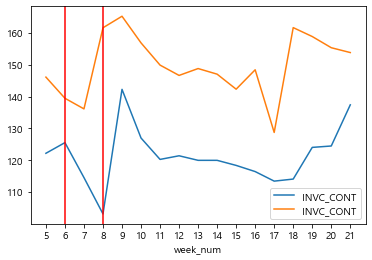

In [43]:
cj_seoul_2019.groupby("week_num")["INVC_CONT"].mean().plot()
cj_seoul_2020.groupby("week_num")["INVC_CONT"].mean().plot()
plt.xticks(range(5,22))
plt.axvline(x=6, color='red')
plt.axvline(x=8, color='red')
plt.legend()

주황이가 2020년 파랑이가 2019년
마찬가지로 보면 2019년 6-8주차 사이에는 물류가 왜인지는 모르겠지만 급감하는 반면에 2020년 6-8주차에는 상승 -> 전반적인 기울기 반대

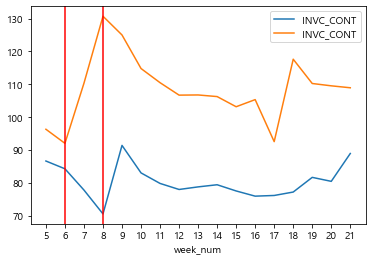

In [44]:
cj_daegu_2019.groupby("week_num")["INVC_CONT"].mean().plot()
cj_daegu_2020.groupby("week_num")["INVC_CONT"].mean().plot()
plt.xticks(range(5,22))
plt.axvline(x=6, color='red')
plt.axvline(x=8, color='red')
plt.legend()

주황이가 2020년 파랑이가 2019년 대구에서 더 극명한 차이를 보여줌

In [45]:
# 서울의 6-8주차 물류 변화지수
(cj_seoul_2020_sep['INVC_CONT'].mean() * 100) / cj_seoul_2019_sep['INVC_CONT'].mean()

127.22036094010637

In [46]:
# 대구의 6-8주차 물류 변화지수
(cj_daegu_2020_sep['INVC_CONT'].mean() * 100) / cj_daegu_2019_sep['INVC_CONT'].mean()

142.99058013783994

확실히 대구가 서울에 비해 확 치고 오른듯한 모습

둘이 합쳐보기

In [47]:
# 19년 20년 퉁치기
cj_2019 = cj[cj['year'] == 2019]
cj_2020 = cj[cj['year'] == 2020]

cj_2019_sep = cj_2019[cj_2019['INVC_CONT'].isin(range(6, 9))]
cj_2020_sep = cj_2020[cj_2020['INVC_CONT'].isin(range(6, 9))]

In [48]:
(cj_2020_sep['INVC_CONT'].mean() * 100) / cj_2019_sep['INVC_CONT'].mean()

100.4120618855597

!!? 뭐여..

### -> 이로 미루어보아 6-8주차의 서울 / 대구의 물류지수의 변동 폭은 다르다
#### (통계적으로 검증해보기)

# 구별로 한번 보자

In [49]:
from matplotlib import font_manager, rc
import platform 

# 한글 폰트 사용
if platform.system() == 'Windows': 
    path = 'c:/Windows/Fonts/malgun.ttf'
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
elif platform.system() == 'Darwin':
    rc('font', family='AppleGothic')

In [50]:
cj_seoul_gu_sep = cj_seoul_2019_sep.pivot_table(index=['CTGG_NM', 'week_num'], values='INVC_CONT', aggfunc='mean')

cj_seoul_gu_sep.columns =['INVC_CONT_2019']
cj_seoul_gu_sep['INVC_CONT_2020'] = cj_seoul_2020_sep.pivot_table(index=['CTGG_NM', 'week_num'], values='INVC_CONT', aggfunc='mean')['INVC_CONT']

cj_seoul_gu_sep.reset_index(inplace= True)

([<matplotlib.axis.XTick at 0x1733c71bcd0>,
 <a list of 3 Text major ticklabel objects>)

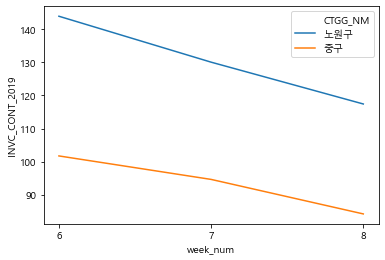

In [51]:
sns.lineplot(x='week_num', y = 'INVC_CONT_2019',hue='CTGG_NM', data = cj_seoul_gu_sep)
plt.xticks(range(6,9))


..? 2019년도에는 감소하는 모습

([<matplotlib.axis.XTick at 0x1733c1e5880>,
 <a list of 3 Text major ticklabel objects>)

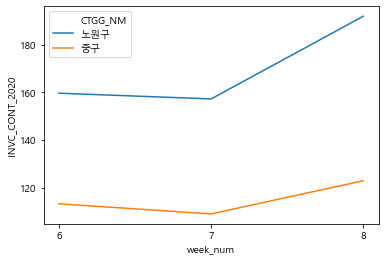

In [52]:
sns.lineplot(x='week_num', y = 'INVC_CONT_2020',hue='CTGG_NM', data = cj_seoul_gu_sep)
plt.xticks(range(6,9))


2020년도에는 반대로 증가

([<matplotlib.axis.XTick at 0x17350664280>,
 <a list of 3 Text major ticklabel objects>)

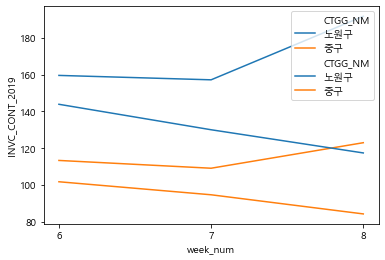

In [53]:
sns.lineplot(x='week_num', y = 'INVC_CONT_2020',hue='CTGG_NM', data = cj_seoul_gu_sep)
sns.lineplot(x='week_num', y = 'INVC_CONT_2019',hue='CTGG_NM', data = cj_seoul_gu_sep)
plt.xticks(range(6,9))

둘다 2020년에 증가하는 모습을 보임

In [54]:
cj_seoul_gu_gap = cj_seoul_gu_sep.groupby("CTGG_NM")[['INVC_CONT_2019', 'INVC_CONT_2020']].mean()
cj_seoul_gu_gap['decrease_ratio'] = (cj_seoul_gu_gap['INVC_CONT_2020'] * 100) / cj_seoul_gu_gap['INVC_CONT_2019']
cj_seoul_gu_gap

,INVC_CONT_2019,INVC_CONT_2020,decrease_ratio
CTGG_NM,,,
노원구,130.462909,169.562397,129.969811
중구,93.547142,115.150102,123.093126


#### 서울의 물류 변동지수가 127.22036094010637임을 감안할때
#### 노원구가 훨씬 더 물류를 많이 시킴, 이에 반해 중구는 별로

하지만 유동인구로 미루어 보았을때 중구는 유동인구가 엄청 줄었지만 물류도 별로 안시킴.

노원구는 유동인구가 서울 평균대비 별로 안줄었는데 물류는 많이 시킴

한번 생각해보기

# 이제 행정동별로 봐보자잉

In [55]:
cj_seoul_dong_sep = cj_seoul_2019_sep.pivot_table(index=['CTGG_NM','HDNG_NM', 'week_num'], values='INVC_CONT', aggfunc='mean')
cj_seoul_dong_sep.columns = ['INVC_CONT_2019']

cj_seoul_dong_sep['INVC_CONT_2020'] = cj_seoul_2020_sep.pivot_table(index=['CTGG_NM','HDNG_NM', 'week_num'], values='INVC_CONT', aggfunc='mean')['INVC_CONT']

cj_seoul_dong_sep.reset_index(inplace=True)

cj_seoul_dong_gap = cj_seoul_dong_sep.pivot_table(index=['CTGG_NM', 'HDNG_NM'], values = ['INVC_CONT_2019', 'INVC_CONT_2020'], aggfunc='mean')

cj_seoul_dong_gap['decrease_ratio'] = (cj_seoul_dong_gap['INVC_CONT_2020'] * 100) / cj_seoul_dong_gap['INVC_CONT_2019']
cj_seoul_dong_gap

INVC_CONT_2019  INVC_CONT_2020  decrease_ratio
CTGG_NM HDNG_NM                                                
노원구     공릉1동         196.553059      244.582698      124.435967
        공릉2동         214.570048      272.951265      127.208465
        상계10동         64.062512       95.677659      149.350464
        상계1동         178.269431      233.716943      131.103208
        상계2동         127.784314      143.350760      112.181813
        상계3.4동        91.763071      124.335601      135.496339
        상계5동         101.202345      127.498902      125.984138
        상계6.7동       188.252073      236.457752      125.606984
        상계8동         116.404342      157.057654      134.924223
        상계9동         114.030873      178.911765      156.897654
        월계1동         109.599356      140.985796      128.637431
        월계2동         106.697606      133.878248      125.474463
        월계3동         141.455938      178.132779      125.928103
        중계1동         124.116469      177.600713      143.091980
        중계2.3동       158.683382      199.076262      125.455016
        중계4동          90.296791      116.709529      129.251026
        중계본동         116.496382      153.841206      132.056639
        하계1동         130.705882      169.722901      129.851004
        하계2동         103.450980      133.022657      128.585207
중구      광희동          136.165441      158.527686      116.422849
        다산동           87.529341      112.367536      128.376993
        동화동           65.694298       69.330738      105.535397
        명동           153.429293      170.086537      110.856626
        소공동          120.598079      145.667388      120.787486
        신당동          134.170366      184.923690      137.827521
        신당제5동         64.609108       91.148693      141.077156
        약수동           91.376592      114.573077      125.385587
        을지로동          66.427554       75.349124      113.430525
        장충동           47.495898       57.559098      121.187515
        중림동           77.767354      105.337344      135.451881
        청구동           74.740119       92.337551      123.544828
        필동            60.506628       70.969094      117.291438
        황학동           94.026322      143.779846      152.914463
        회현동          125.173406      134.610477      107.539198

# 노원구부터 시각화

In [56]:
def plot_region_dong_sensitivity(df, x_axis, gu_name, rot_x = True, show_xlabel = True):
    plt.figure(figsize=(18, 6))
    
    pal = sns.color_palette("Blues_r", df.shape[0])
    
    top_down_index = df['decrease_ratio'].sort_values(ascending=False).index
    plot_order = df.iloc[top_down_index]['HDNG_NM'].values
    sns.barplot(x = x_axis, y='decrease_ratio', data=df, order=plot_order)
    plt.axhline(cj_seoul_gu_gap.loc[gu_name, 'decrease_ratio'])

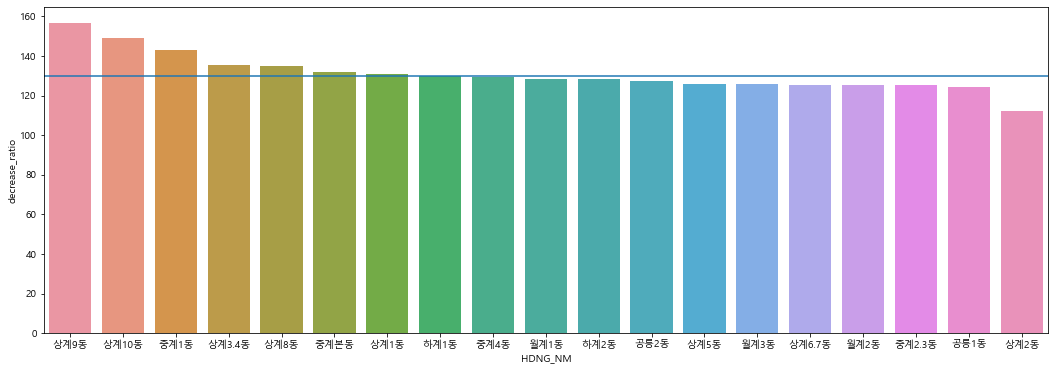

In [57]:
plot_region_dong_sensitivity(cj_seoul_dong_gap.xs("노원구").reset_index(), 'HDNG_NM', '노원구')

# 중구

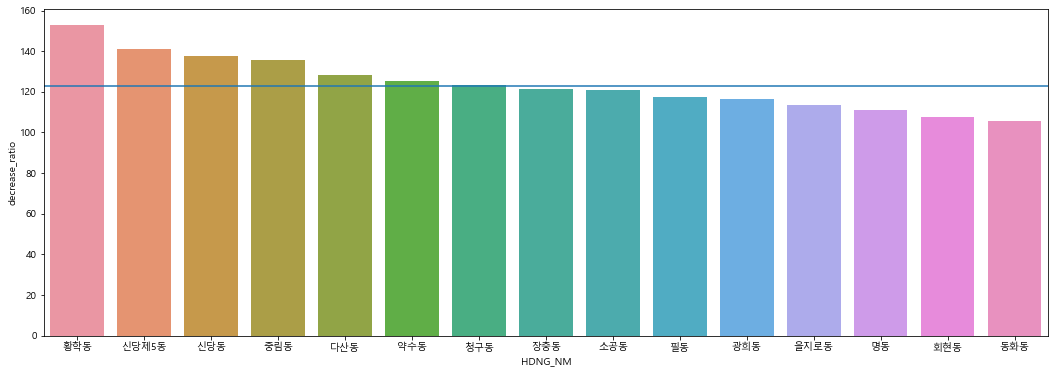

In [58]:
plot_region_dong_sensitivity(cj_seoul_dong_gap.xs("중구").reset_index(), 'HDNG_NM', '중구')

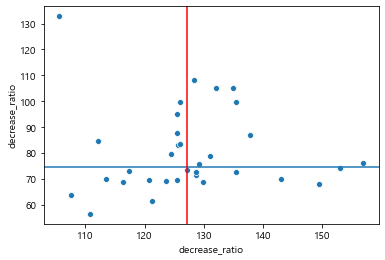

In [59]:
sns.scatterplot(x = cj_seoul_dong_gap['decrease_ratio'], y = sk_seoul_dong_gap['decrease_ratio'])
plt.axhline(74.68449978696867)
plt.axvline(127.22036094010637, color='r')

## 거지같은 동화동 제거

In [60]:
cj_seoul_dong_gap2 = cj_seoul_dong_gap.reset_index()
donghwadong_index = cj_seoul_dong_gap2[cj_seoul_dong_gap2['HDNG_NM'] == '동화동'].index[0]
cj_seoul_dong_gap2.drop(donghwadong_index, axis=0, inplace=True)

sk_seoul_dong_gap2 = sk_seoul_dong_gap.reset_index()
donghwadong_index = sk_seoul_dong_gap2[sk_seoul_dong_gap2['HDNG_NM'] == '동화동'].index[0]
sk_seoul_dong_gap2.drop(donghwadong_index, axis=0, inplace=True)

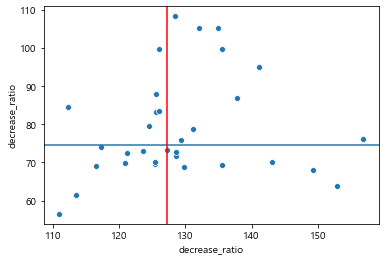

In [61]:
sns.scatterplot(x = cj_seoul_dong_gap2['decrease_ratio'], y = sk_seoul_dong_gap2['decrease_ratio'])
plt.axhline(74.68449978696867)
plt.axvline(127.22036094010637, color='r')

# 이쯤에서.. 차라리 그냥 유동인구로 간단하게 집단을 나누고 19-21주차의 카드와 물류로 구독경제와 드라이브 쓰루 하면 되지않을까 생각이 들기 시작..

## 일단 단편적으로 보기위해서 노원구만 한번 보기로 결정!

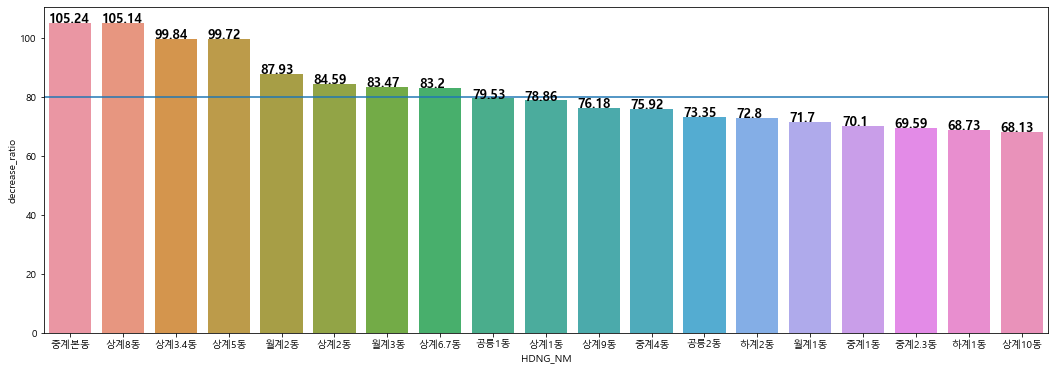

In [64]:
plot_region_dong_sensitivity(sk_seoul_dong_gap.xs("노원구").reset_index(), 'HDNG_NM', '노원구')

#### 나의 임의적 가정하에 노원구 전체의 유동지수인 80 +- 7 을 기준으로 노멀한 지역으로 잡고 그거보다 작으면 유동인구가 많이 하락한 유동인구 민감지역, 그거보다 크면 유동인구가 크게 하락하지 않거나 오히려 상승한 이상지역이라 판단

#### 두드러지는 차이를 보이는 상위 4개를 민감지역, 하위 4개를 이상지역, 나머지를 보통지역이라 분류

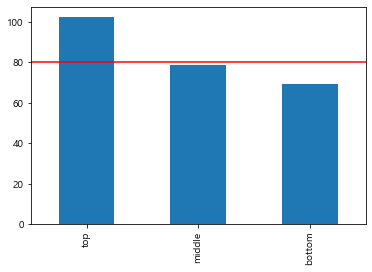

In [66]:
nowon_data = sk_seoul_dong_gap.xs("노원구").reset_index().sort_values(by='decrease_ratio', ascending=False)
nowon_data.reset_index(drop=True, inplace=True)

# 지역 분류 top : 둔감, middle: 보통, bottom : 민감지역
top_districks = nowon_data[:4]
middle_districks = nowon_data[4:-4]
bottom_districks = nowon_data[-4:]

sensitive_dic = {
    'top' : top_districks['decrease_ratio'].mean(),
    'middle' : middle_districks['decrease_ratio'].mean(),
    'bottom' : bottom_districks['decrease_ratio'].mean()
}

pd.Series(sensitive_dic).plot(kind='bar')
plt.axhline(sk_seoul_gu_gap.loc['노원구', 'decrease_ratio'], color='red')

## 집단별로 평균을 먹여본 결과 노원구 유동지수 평균을 기준으로 집단이 나뉘는 모습

# 카드를 한번 보자꾸나

In [67]:
card.drop(['GU_CD', 'DONG_CD', '구코드', '행정동코드'], axis=1)

,MCT_CAT_CD,SEX_CD,AGE_CD,USE_CNT,USE_AMT,year,month,day,week_num,day_of_week,day_of_week_kr,CTPV_NM,CTGG_NM,HDNG_NM
0,10,F,25,11,595,2019,2,1,4,4,금,대구광역시,중구,동인동
1,10,F,50,5,243,2019,2,1,4,4,금,대구광역시,중구,동인동
2,10,F,55,5,27,2019,2,1,4,4,금,대구광역시,중구,동인동
3,10,M,20,11,243,2019,2,1,4,4,금,대구광역시,중구,동인동
4,10,M,25,11,433,2019,2,1,4,4,금,대구광역시,중구,동인동
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2537748,81,M,45,19,127,2020,5,31,22,6,일,서울특별시,노원구,상계10동
2537749,81,M,50,33,211,2020,5,31,22,6,일,서울특별시,노원구,상계10동
2537750,81,M,55,9,61,2020,5,31,22,6,일,서울특별시,노원구,상계10동
2537751,81,M,60,19,194,2020,5,31,22,6,일,서울특별시,노원구,상계10동


In [68]:
line = pd.read_excel("card_instruct.xlsx",sheet_name = 2, header=1).drop("Unnamed: 0", axis=1)
line_code = pd.DataFrame(line['업종코드 (32개 분류)'].dropna())
line_code.reset_index(drop=True, inplace = True)

code_list = []
line_list = []

for line in line_code['업종코드 (32개 분류)']:
    code = line[-3:-1]
    name = line[:-4]
    
    code_list.append(code)
    line_list.append(name)
    
line_dic = {
    'MCT_CAT_CD' : code_list,
    'MCT_CAT_NM' : line_list
}

#업종별 테이블 생성
line_table = pd.DataFrame(line_dic)
# 카드 데이터와 맞추기 위해 타입변경
line_table['MCT_CAT_CD'] = line_table['MCT_CAT_CD'].astype("int64")

In [69]:
card = card.merge(line_table, how='left', on = 'MCT_CAT_CD')
card = card.drop(["GU_CD", "DONG_CD", '구코드', '행정동코드'], axis=1)

# 칼럼 정렬
card_cols = ['MCT_CAT_CD', 'MCT_CAT_NM','CTPV_NM', 'CTGG_NM', 'HDNG_NM', 'SEX_CD', "AGE_CD", "year", "month", "day", "week_num","day_of_week", "day_of_week_kr", "USE_CNT", "USE_AMT"]
card = card[card_cols]

### 지수를 생성할껀데 이름하야 소비지수임.
보통 주차별로 소비가 하락하는게 일반적일 수 있으니까 2019년도의 각 주차의 카테고리 / 성별 / 나이 / 행정동 을 기준으로 지수를 생성할것.

In [71]:
consume_table = card.pivot_table(index=["week_num", "MCT_CAT_NM", "CTPV_NM", "CTGG_NM", "HDNG_NM", "SEX_CD", "AGE_CD", "year"], values = ['USE_CNT', 'USE_AMT'], aggfunc='mean').reset_index()

In [74]:
consume_index = card.pivot_table(index=["week_num", "MCT_CAT_NM", "CTPV_NM", "CTGG_NM", "HDNG_NM", "SEX_CD", "AGE_CD", "year"], values = ['USE_CNT', 'USE_AMT'], aggfunc='mean').reset_index()

In [73]:
consume_table

,week_num,MCT_CAT_NM,CTPV_NM,CTGG_NM,HDNG_NM,SEX_CD,AGE_CD,year,USE_AMT,USE_CNT
0,4,가구,대구광역시,수성구,고산2동,F,65,2019,119.0,5.0
1,4,가구,대구광역시,수성구,고산2동,M,50,2020,527.0,5.0
2,4,가구,대구광역시,수성구,두산동,F,55,2019,10820.0,5.0
3,4,가구,대구광역시,수성구,두산동,M,35,2019,13255.0,5.0
4,4,가구,대구광역시,수성구,두산동,M,45,2020,1686.0,5.0
...,...,...,...,...,...,...,...,...,...,...
579280,22,직물,서울특별시,중구,회현동,F,40,2020,56.0,5.0
579281,22,직물,서울특별시,중구,회현동,F,50,2020,112.0,5.0
579282,22,직물,서울특별시,중구,회현동,M,55,2020,243.0,5.0
579283,22,직물,서울특별시,중구,회현동,M,60,2020,323.0,9.0


In [75]:
consume_table_2019 = consume_index[consume_index['year'] == 2019]
consume_table_2020 = consume_index[consume_index['year'] == 2020]

# 분석의 대상에서 제외되는 2019년도 4주차, 2020년도 4주차, 22주차 데이터 제거
remove_index_201904 = consume_table_2019[consume_table_2019['week_num'] == 4].index
remove_index_202004 = consume_table_2020[consume_table_2020['week_num'] == 4].index
remove_index_202022 = consume_table_2020[consume_table_2020['week_num'] == 22].index

consume_table_2019.drop(remove_index_201904, axis=0, inplace=True)
consume_table_2020.drop(remove_index_202004, axis=0, inplace=True)
consume_table_2020.drop(remove_index_202022, axis=0, inplace=True)

# 인덱스 정리
consume_table_2019.reset_index(drop=True, inplace=True)
consume_table_2020.reset_index(drop=True, inplace=True)

In [76]:
consume_table_2019.shape, consume_table_2020.shape

((279842, 10), (265709, 10))

> --> 데이터 수가 동일하지 않다

의미 : 2019년에는 있고 2020년에는 없는 데이터들이 있다.

In [77]:
consume_table_total = consume_table_2019.merge(consume_table_2020, how='inner', on = ['week_num', 'MCT_CAT_NM', 'CTPV_NM', 'CTGG_NM', 'HDNG_NM', 'SEX_CD',
       'AGE_CD'])
consume_table_total.shape

(235626, 13)

> 결론 : 2019년과 2020년에 모두 동일하게 있는 235626개의 데이터만 사용

In [78]:
consume_table_total

,week_num,MCT_CAT_NM,CTPV_NM,CTGG_NM,HDNG_NM,SEX_CD,AGE_CD,year_x,USE_AMT_x,USE_CNT_x,year_y,USE_AMT_y,USE_CNT_y
0,5,가구,대구광역시,수성구,고산2동,M,45,2019,974.000000,5.000000,2020,1845.000000,5.000000
1,5,가구,대구광역시,수성구,두산동,F,65,2019,2976.000000,5.000000,2020,4422.000000,5.000000
2,5,가구,대구광역시,수성구,두산동,M,45,2019,5194.000000,5.000000,2020,26350.000000,5.000000
3,5,가구,대구광역시,수성구,두산동,M,60,2019,7033.000000,5.000000,2020,5518.000000,5.000000
4,5,가구,대구광역시,수성구,상동,F,40,2019,5410.000000,5.000000,2020,646.000000,5.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
235621,21,직물,서울특별시,중구,회현동,M,45,2019,579.000000,5.666667,2020,760.000000,6.800000
235622,21,직물,서울특별시,중구,회현동,M,50,2019,460.000000,7.333333,2020,1552.571429,9.285714
235623,21,직물,서울특별시,중구,회현동,M,55,2019,266.333333,7.000000,2020,1733.428571,10.714286
235624,21,직물,서울특별시,중구,회현동,M,60,2019,1907.000000,4.000000,2020,1154.000000,15.857143


In [79]:
# 전체의 소비지수 보기
consume_week_index = consume_table_total.pivot_table(index='week_num', values=['USE_CNT_x', 'USE_AMT_x', 'USE_CNT_y', 'USE_AMT_y'], aggfunc='mean')
consume_week_index['consume_ratio_AMT'] = consume_week_index['USE_AMT_y'] * 100 / consume_week_index['USE_AMT_x']
consume_week_index['consume_ratio_CNT'] = consume_week_index['USE_CNT_y'] * 100 / consume_week_index['USE_CNT_x']

In [80]:
consume_week_index

,USE_AMT_x,USE_AMT_y,USE_CNT_x,USE_CNT_y,consume_ratio_AMT,consume_ratio_CNT
week_num,,,,,,
5,2055.955223,1959.313990,78.124691,80.007063,95.299449,102.409445
6,2193.432293,2052.856986,83.916070,81.334366,93.591081,96.923468
7,2279.803224,1913.532854,86.835074,75.566995,83.934124,87.023586
8,2630.485692,1822.053330,96.227940,67.177796,69.266803,69.811113
9,2341.267574,1591.880508,96.056548,66.542982,67.992250,69.274800
10,2296.318710,1617.821119,93.330284,68.791763,70.452813,73.707868
11,2295.017178,1663.531374,92.874532,69.587116,72.484485,74.925940
12,2471.113369,1853.814111,94.194753,72.897463,75.019387,77.390152
13,2271.900324,1810.546868,93.106659,73.415601,79.693059,78.851074


# 주차별 소비 금액지수 시각화

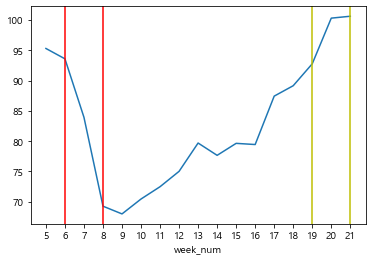

In [81]:
consume_week_index['consume_ratio_AMT'].plot()
plt.xticks(range(5, 22))
# 주차별 소비금액지수가 급감했다가
plt.axvline(6,color = 'r')
plt.axvline(8,color = 'r')

plt.axvline(19, color='y')
plt.axvline(21, color='y')

# 주차별 소비 건수지수 시각화

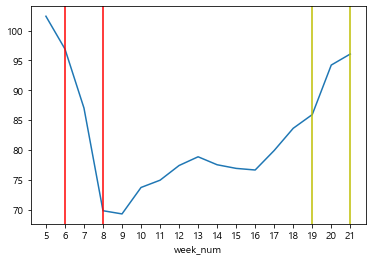

In [82]:
consume_week_index['consume_ratio_CNT'].plot()
plt.xticks(range(5, 22))
# 주차별 소비금액지수가 급감했다가
plt.axvline(6,color = 'r')
plt.axvline(8,color = 'r')

plt.axvline(19, color='y')
plt.axvline(21, color='y')

-> 금액과 유사하게 건수가 6-8에 하락했다가 19-21주차에 정상 궤도로 들어가고있음

## 결론 : 마찬가지로 19-21주차에 뉴노멀의 소비형태를 보여줄 수 있을것!

## 일단 업종별로 한번 봐보자 (x 주차별)

In [83]:
consume_table_line = consume_table_total.pivot_table(index=['week_num', 'MCT_CAT_NM'], values=['USE_CNT_x', 'USE_AMT_x', 'USE_CNT_y', 'USE_AMT_y'], aggfunc='mean').reset_index()

consume_table_line.set_index('week_num', inplace=True)

# 업종별 주차별 소비지수 계산
consume_table_line['consume_line_ratio_AMT'] = consume_table_line['USE_AMT_y'] * 100 / consume_table_line['USE_AMT_x']
consume_table_line['consume_line_ratio_CNT'] = consume_table_line['USE_CNT_y'] * 100 / consume_table_line['USE_CNT_x']

# 유니크한 업종들 전체
lines = consume_table_total['MCT_CAT_NM'].unique()

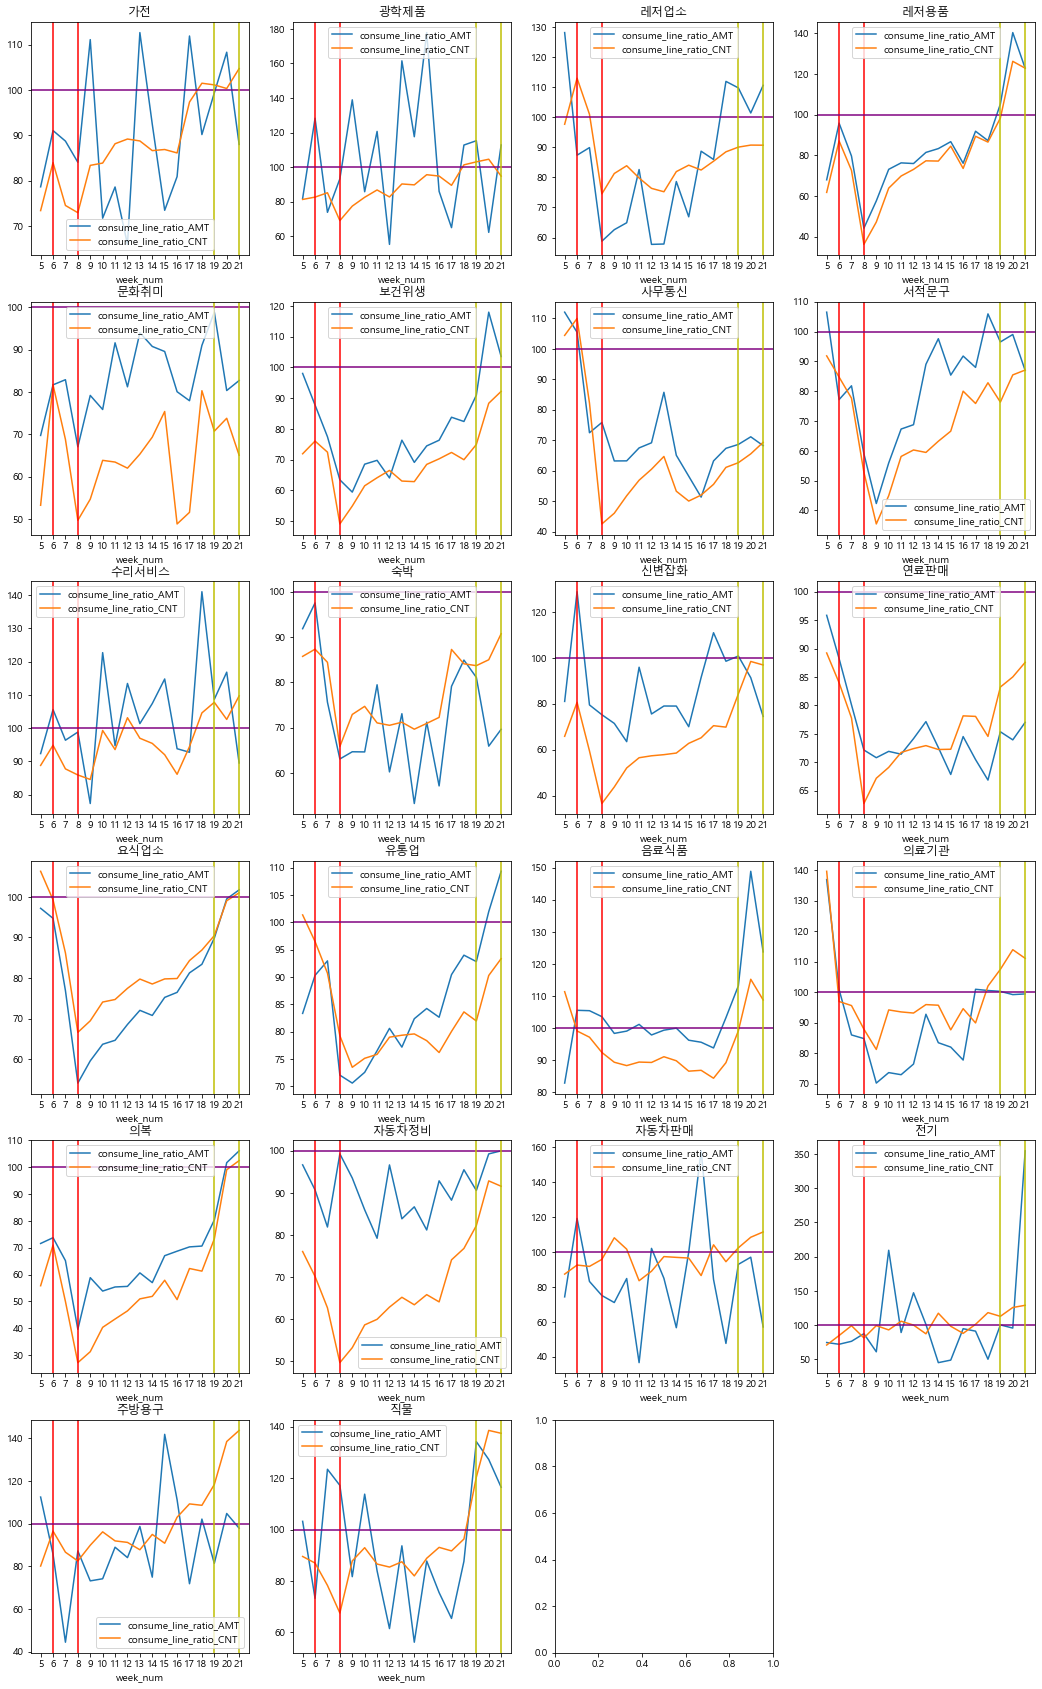

In [84]:
tmp_df = pd.DataFrame()
fig = plt.figure(figsize=(18, 30))

for idx, line in enumerate(lines):
    tmp_df = consume_table_line[consume_table_line['MCT_CAT_NM'] == line]    
    tmp_df['consume_line_ratio_AMT'].plot()
    tmp_df['consume_line_ratio_CNT'].plot()
    plt.axvline(6,color = 'r')
    plt.axvline(8,color = 'r')
    plt.axhline(100, color="purple")
    plt.xticks(range(5, 22))
    plt.title(line)
    plt.axvline(19, color='y')
    plt.axvline(21, color='y')
    plt.legend()
    
    plt.subplot(6,4,idx+1)

## AMT(금액)와 CNT(빈도)와 함께 추세를 따라가는 애들이 있는 반면 추세와 거꾸로 가는 친구들도 있다. 이것도 한번 생각해보기

# 서울지역과 대구 지역의 트랜드가 다를수도 있지 않을까?

In [85]:
consume_week_index_si = consume_table_total.pivot_table(index=['week_num','CTPV_NM'], values=['USE_CNT_x', 'USE_AMT_x', 'USE_CNT_y', 'USE_AMT_y'], aggfunc='mean')
consume_week_index_si = consume_week_index_si.reset_index()

In [86]:
consume_week_index_si['consume_ratio_AMT'] = consume_week_index_si['USE_AMT_y'] * 100 / consume_week_index_si['USE_AMT_x']
consume_week_index_si['consume_ratio_CNT'] = consume_week_index_si['USE_CNT_y'] * 100 / consume_week_index_si['USE_CNT_x']

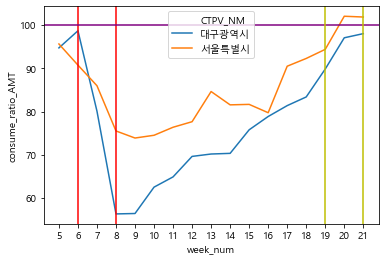

In [87]:
sns.lineplot(x='week_num', y='consume_ratio_AMT',hue='CTPV_NM', data = consume_week_index_si)
plt.axvline(6,color = 'r')
plt.axvline(8,color = 'r')
plt.axhline(100, color="purple")
plt.xticks(range(5, 22))
plt.axvline(19, color='y')
plt.axvline(21, color='y')

plt.show()

## 서울과 대구의 주차별 카드매출 소비량은 비슷비슷하게 회복

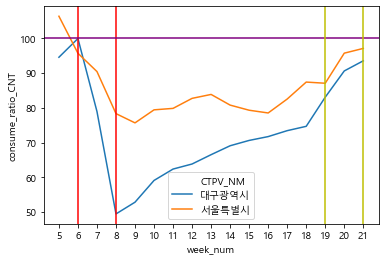

In [88]:
sns.lineplot(x='week_num', y='consume_ratio_CNT',hue='CTPV_NM', data = consume_week_index_si)
plt.axvline(6,color = 'r')
plt.axvline(8,color = 'r')
plt.axhline(100, color="purple")
plt.xticks(range(5, 22))
plt.axvline(19, color='y')
plt.axvline(21, color='y')

plt.show()

## 서울과 대구의 주차별 카드매출 건수도 마찬가지로 비슷비슷하게 회복

# 서울 x 대구의 업종별 비교

In [89]:
consume_table_total_line_si = consume_table_total.pivot_table(index=['week_num', 'MCT_CAT_NM', 'CTPV_NM'], values=['USE_CNT_x', 'USE_AMT_x', 'USE_CNT_y', 'USE_AMT_y'], aggfunc='mean').reset_index()


# 업종별 주차별 소비지수 계산
consume_table_total_line_si['consume_line_ratio_AMT'] = consume_table_total_line_si['USE_AMT_y'] * 100 / consume_table_total_line_si['USE_AMT_x']
consume_table_total_line_si['consume_line_ratio_CNT'] = consume_table_total_line_si['USE_CNT_y'] * 100 / consume_table_total_line_si['USE_CNT_x']

# 유니크한 업종들 전체
lines = consume_table_total_line_si['MCT_CAT_NM'].unique()

# AMT별

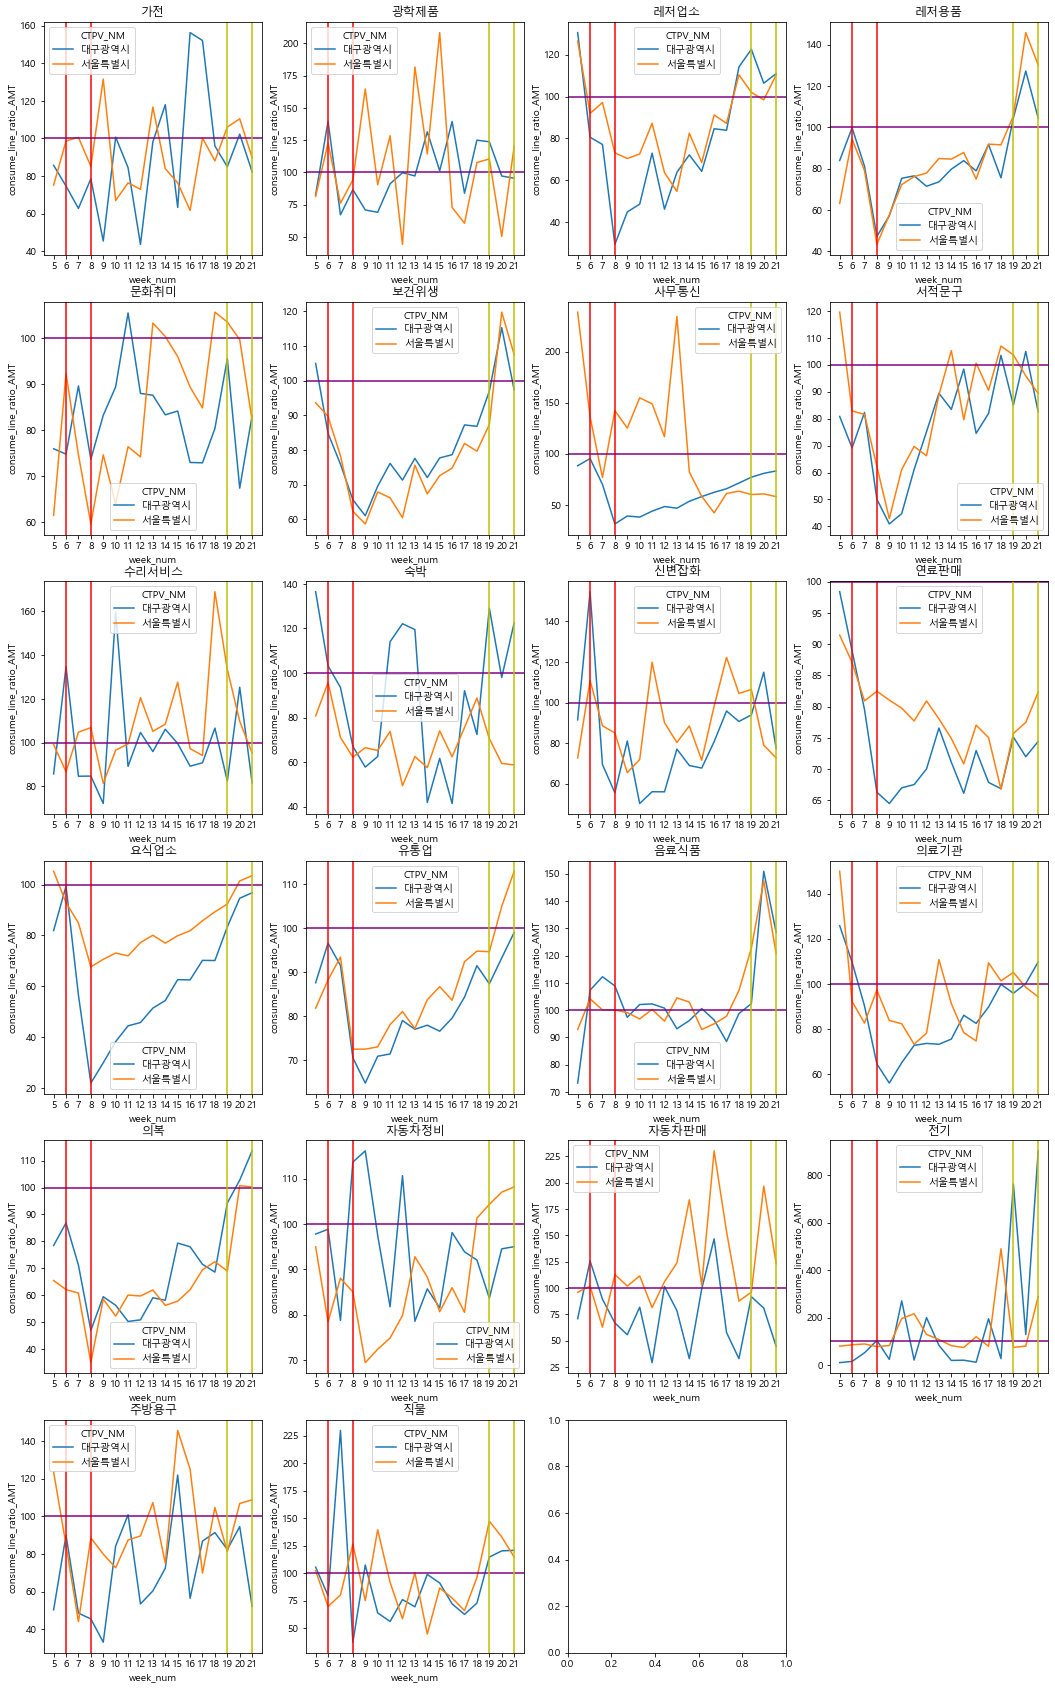

In [90]:
tmp_df = pd.DataFrame()
fig = plt.figure(figsize=(18, 30))

for idx, line in enumerate(lines):
    tmp_df = consume_table_total_line_si[consume_table_total_line_si['MCT_CAT_NM'] == line]    
    sns.lineplot(x='week_num', y='consume_line_ratio_AMT',hue='CTPV_NM', data = tmp_df)
    plt.axvline(6,color = 'r')
    plt.axvline(8,color = 'r')
    plt.axhline(100, color="purple")
    plt.xticks(range(5, 22))
    plt.title(line)
    plt.axvline(19, color='y')
    plt.axvline(21, color='y')
    plt.legend()
    
    plt.subplot(6,4,idx+1)

# CNT별

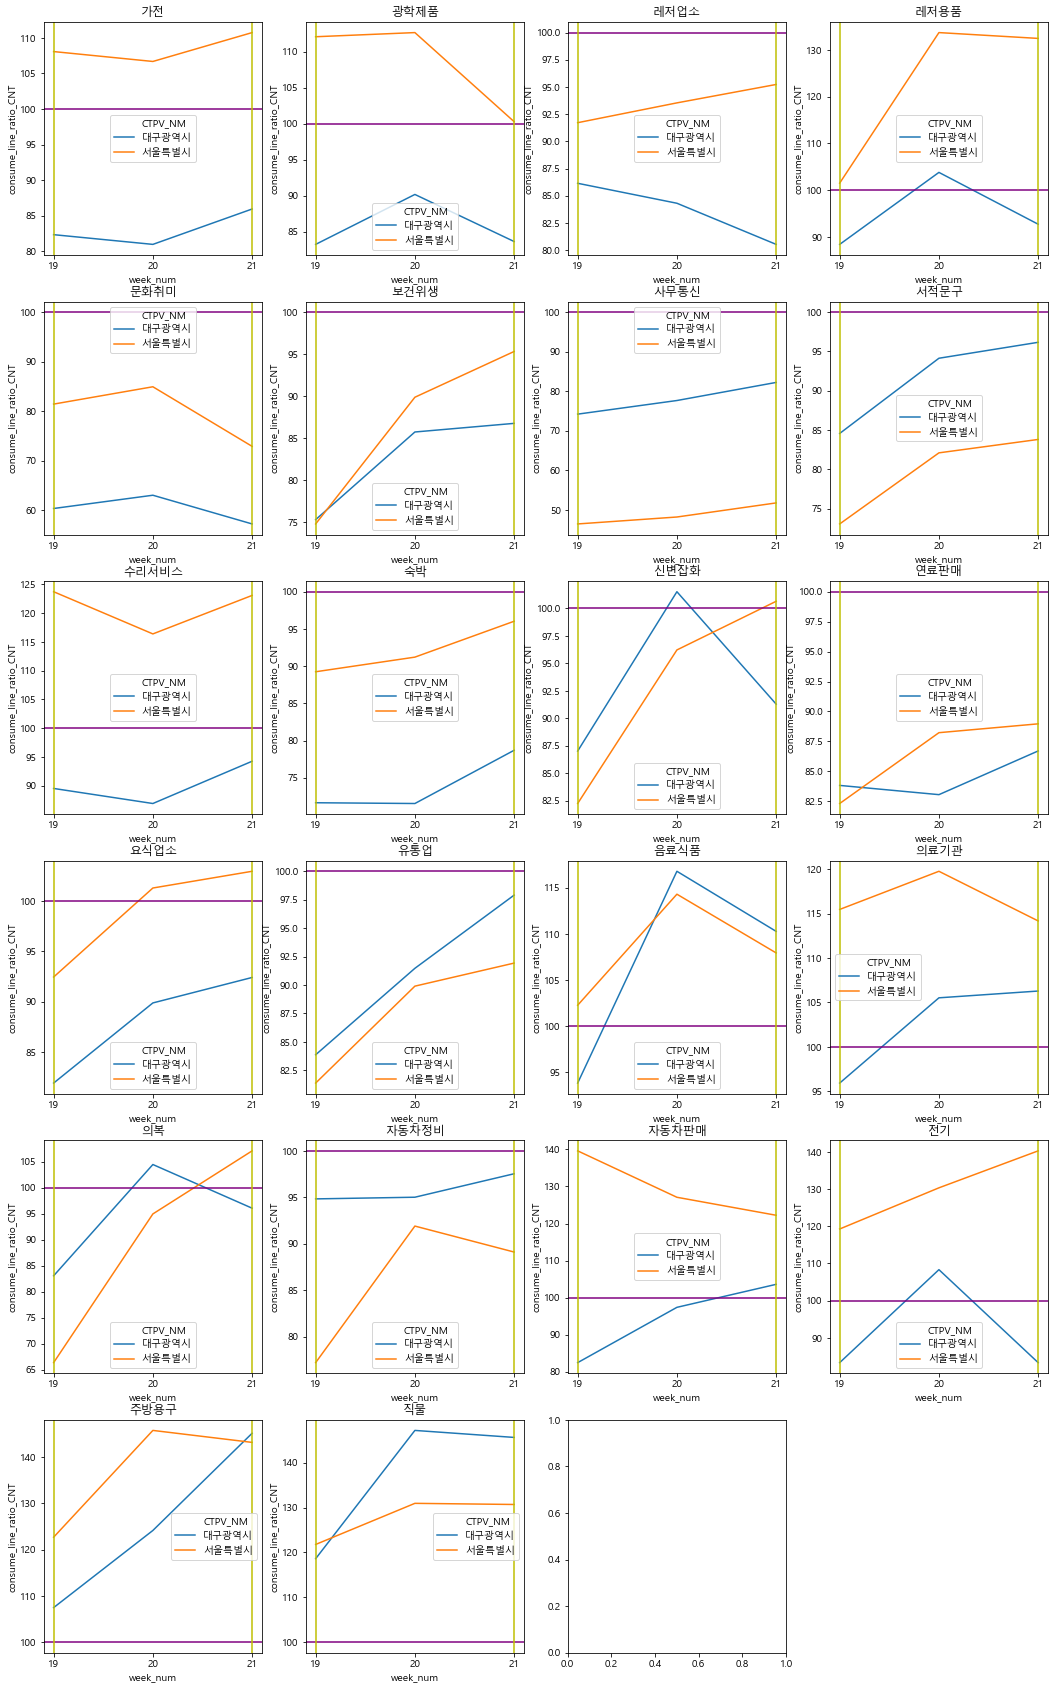

In [91]:
tmp_df = pd.DataFrame()
fig = plt.figure(figsize=(18, 30))

for idx, line in enumerate(lines):
    tmp_df = consume_table_total_line_si[consume_table_total_line_si['MCT_CAT_NM'] == line] 
    tmp_df = tmp_df[tmp_df['week_num'].isin(range(19, 22))]
    sns.lineplot(x='week_num', y='consume_line_ratio_CNT',hue='CTPV_NM', data = tmp_df)
#     plt.axvline(6,color = 'r')
#     plt.axvline(8,color = 'r')
    plt.axhline(100, color="purple")
    plt.xticks(range(19, 22))
    plt.title(line)
    plt.axvline(19, color='y')
    plt.axvline(21, color='y')
    plt.legend()
    
    plt.subplot(6,4,idx+1)

# 서울의 구별!

In [95]:
consume_table_seoul = consume_table_total[consume_table_total['CTPV_NM'] == '서울특별시']
consume_table_daegu = consume_table_total[consume_table_total['CTPV_NM'] == '대구광역시']

In [96]:
consume_table_seoul_gu = consume_table_seoul.pivot_table(index=['week_num', 'CTGG_NM'],  values=['USE_CNT_x', 'USE_AMT_x', 'USE_CNT_y', 'USE_AMT_y'], aggfunc='mean').reset_index()

In [97]:
consume_table_seoul_gu['consume_ratio_AMT'] = consume_table_seoul_gu['USE_AMT_y'] * 100 / consume_table_seoul_gu['USE_AMT_x']
consume_table_seoul_gu['consume_ratio_CNT'] = consume_table_seoul_gu['USE_CNT_y'] * 100 / consume_table_seoul_gu['USE_CNT_x']

# AMT 기준

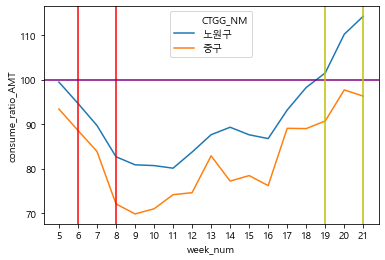

In [98]:
sns.lineplot(x='week_num', y='consume_ratio_AMT',hue='CTGG_NM', data = consume_table_seoul_gu)
plt.axvline(6,color = 'r')
plt.axvline(8,color = 'r')
plt.axhline(100, color="purple")
plt.xticks(range(5, 22))
plt.axvline(19, color='y')
plt.axvline(21, color='y')

plt.show()

# CNT 기준

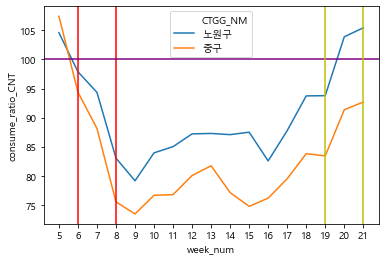

In [99]:
sns.lineplot(x='week_num', y='consume_ratio_CNT',hue='CTGG_NM', data = consume_table_seoul_gu)
plt.axvline(6,color = 'r')
plt.axvline(8,color = 'r')
plt.axhline(100, color="purple")
plt.xticks(range(5, 22))
plt.axvline(19, color='y')
plt.axvline(21, color='y')

plt.show()

# 서울 구별 업종별로

In [100]:
consume_table_total_line_gu = consume_table_seoul.pivot_table(index=['week_num', 'MCT_CAT_NM', 'CTGG_NM'], values=['USE_CNT_x', 'USE_AMT_x', 'USE_CNT_y', 'USE_AMT_y'], aggfunc='mean').reset_index()


# 업종별 주차별 소비지수 계산
consume_table_total_line_gu['consume_line_ratio_AMT'] = consume_table_total_line_gu['USE_AMT_y'] * 100 / consume_table_total_line_gu['USE_AMT_x']
consume_table_total_line_gu['consume_line_ratio_CNT'] = consume_table_total_line_gu['USE_CNT_y'] * 100 / consume_table_total_line_gu['USE_CNT_x']

# 유니크한 업종들 전체
lines = consume_table_total_line_gu['MCT_CAT_NM'].unique()

## AMT 기준

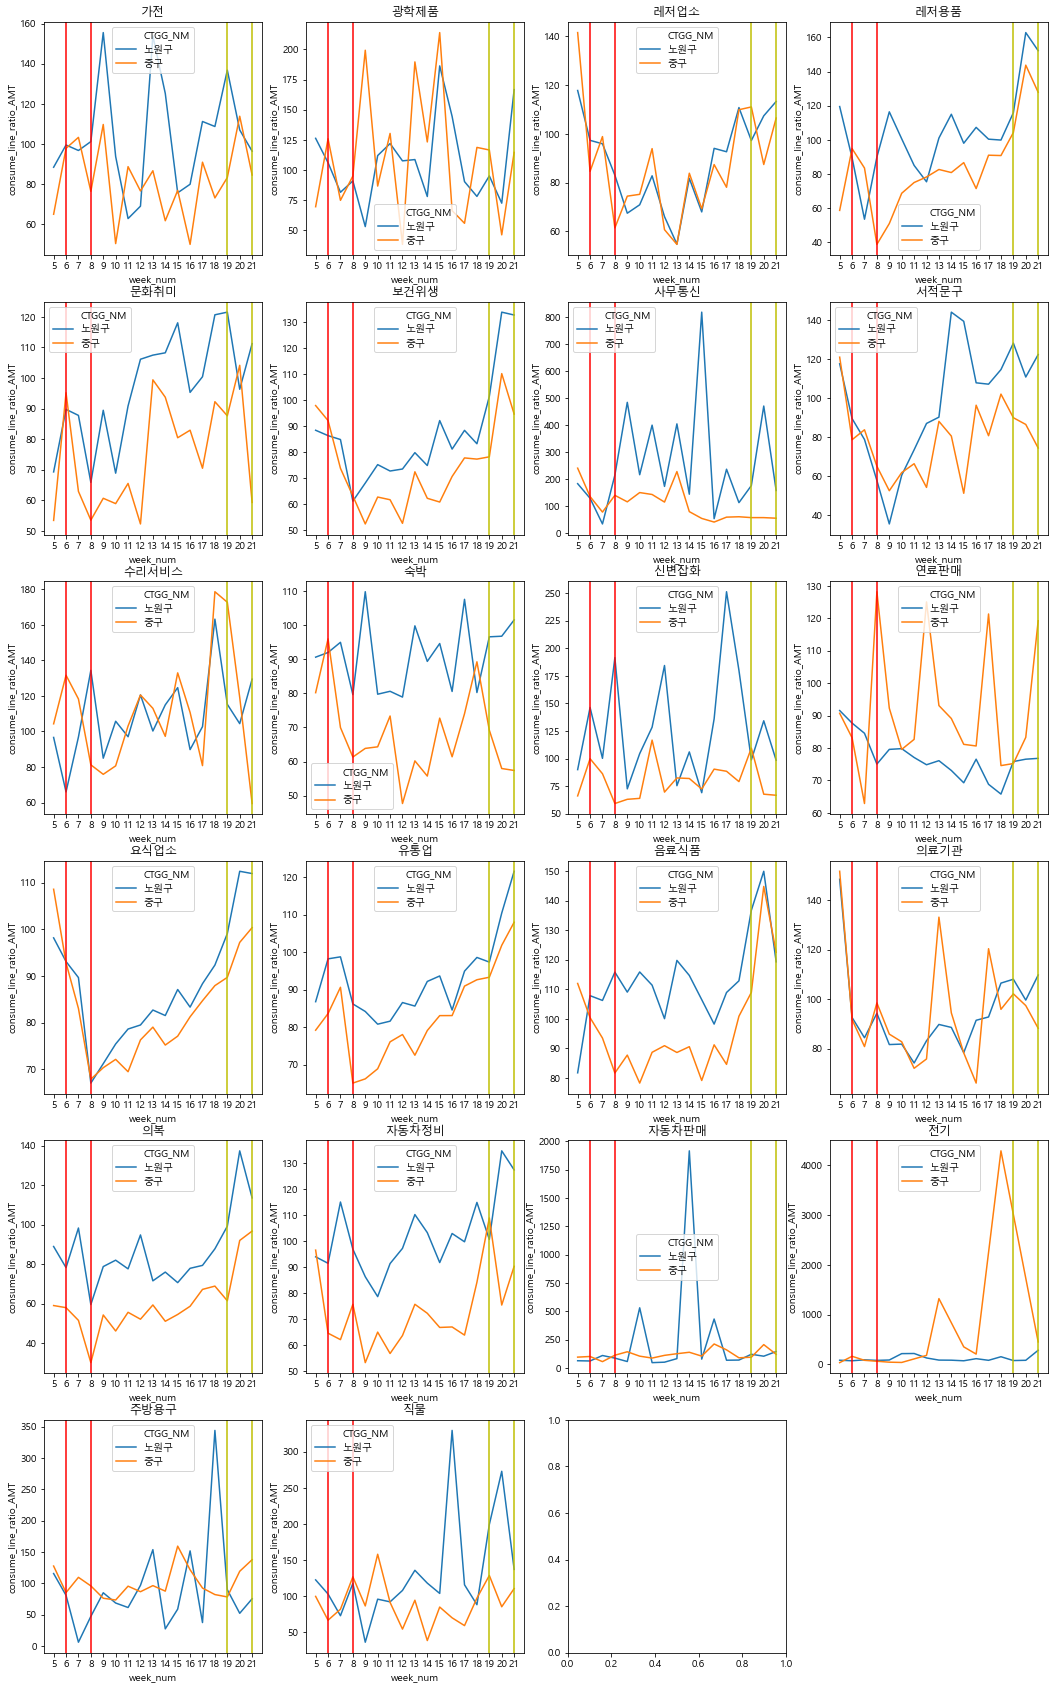

In [102]:
tmp_df = pd.DataFrame()
fig = plt.figure(figsize=(18, 30))

for idx, line in enumerate(lines):
    tmp_df = consume_table_total_line_gu[consume_table_total_line_gu['MCT_CAT_NM'] == line]    
    sns.lineplot(x='week_num', y='consume_line_ratio_AMT',hue='CTGG_NM', data = tmp_df)
    plt.axvline(6,color = 'r')
    plt.axvline(8,color = 'r')
#     plt.axhline(100, color="purple")
    plt.xticks(range(5, 22))
    plt.title(line)
    plt.axvline(19, color='y')
    plt.axvline(21, color='y')
    plt.legend()
    
    plt.subplot(6,4,idx+1)

## CNT 기준

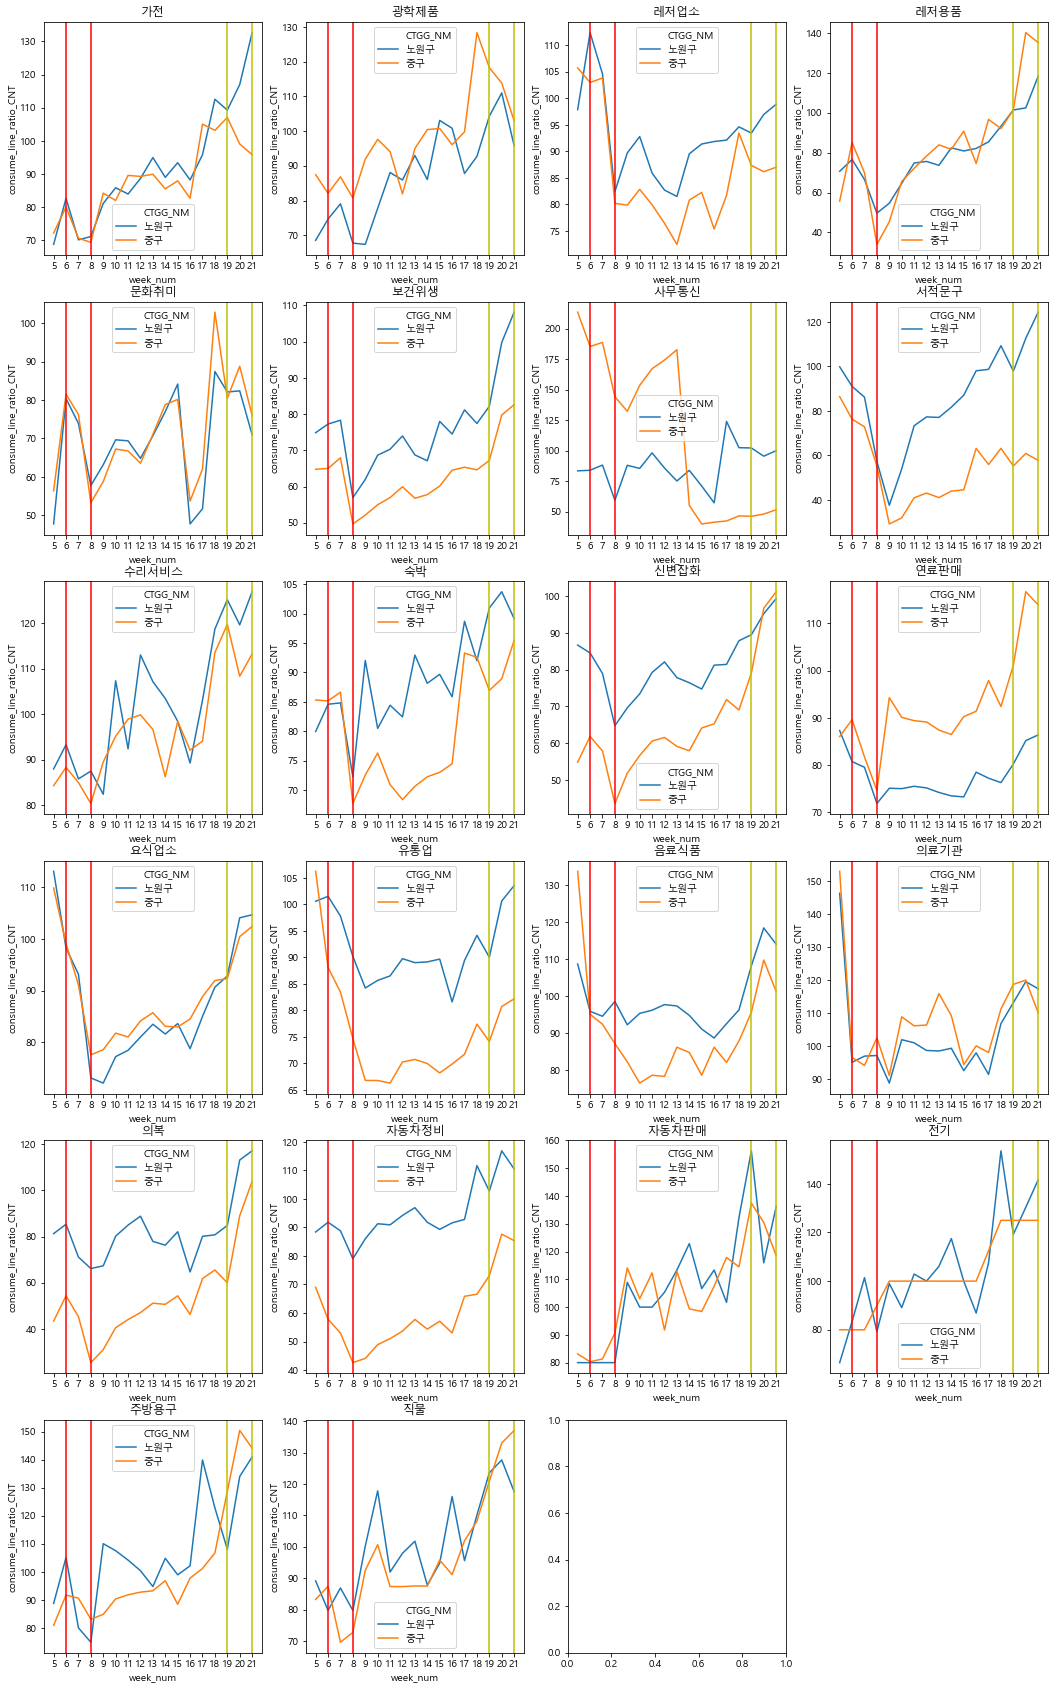

In [103]:
tmp_df = pd.DataFrame()
fig = plt.figure(figsize=(18, 30))

for idx, line in enumerate(lines):
    tmp_df = consume_table_total_line_gu[consume_table_total_line_gu['MCT_CAT_NM'] == line]    
    sns.lineplot(x='week_num', y='consume_line_ratio_CNT',hue='CTGG_NM', data = tmp_df)
    plt.axvline(6,color = 'r')
    plt.axvline(8,color = 'r')
#     plt.axhline(100, color="purple")
    plt.xticks(range(5, 22))
    plt.title(line)
    plt.axvline(19, color='y')
    plt.axvline(21, color='y')
    plt.legend()
    
    plt.subplot(6,4,idx+1)

# 이제 본격적으로 노원구에서 나눠놓은 집단으로 분류해서 소비 행태 보기

In [104]:
consume_table_seoul['consume_ratio_AMT'] = consume_table_seoul['USE_AMT_y'] * 100 / consume_table_seoul['USE_AMT_x']
consume_table_seoul['consume_ratio_CNT'] = consume_table_seoul['USE_CNT_y'] * 100 / consume_table_seoul['USE_CNT_x']

# 노원구만 뽑기
consume_table_seoul_nowon = consume_table_seoul[consume_table_seoul['CTGG_NM'] == '노원구']

# top, middle, bottom 뽑기
consume_nowon_top = consume_table_seoul_nowon[consume_table_seoul_nowon['HDNG_NM'].isin(top_districks['HDNG_NM'].tolist())]
consume_nowon_middle = consume_table_seoul_nowon[consume_table_seoul_nowon['HDNG_NM'].isin(middle_districks['HDNG_NM'].tolist())]
consume_nowon_bottom = consume_table_seoul_nowon[consume_table_seoul_nowon['HDNG_NM'].isin(bottom_districks['HDNG_NM'].tolist())]

# 일단 집단별 전반적인 카드 소비량

In [105]:
consume_nowon_top_total = consume_nowon_top.pivot_table(index=['week_num'], values= ['consume_ratio_AMT',  'consume_ratio_CNT'], aggfunc='mean')
consume_nowon_middle_total = consume_nowon_middle.pivot_table(index=['week_num'], values= ['consume_ratio_AMT',  'consume_ratio_CNT'], aggfunc='mean')
consume_nowon_bottom_total = consume_nowon_bottom.pivot_table(index=['week_num'], values= ['consume_ratio_AMT',  'consume_ratio_CNT'], aggfunc='mean')

# 소비 총액

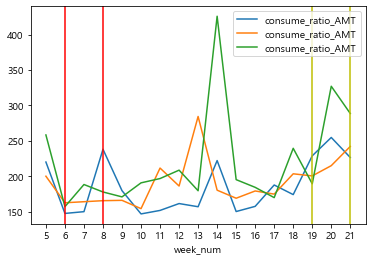

In [106]:
consume_nowon_top_total['consume_ratio_AMT'].plot()
consume_nowon_middle_total['consume_ratio_AMT'].plot()
consume_nowon_bottom_total['consume_ratio_AMT'].plot()
plt.axvline(6,color = 'r')
plt.axvline(8,color = 'r')
plt.xticks(range(5, 22))
plt.axvline(19, color='y')
plt.axvline(21, color='y')
plt.legend()

# 소비 건수

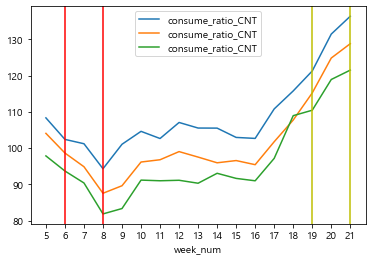

In [107]:
consume_nowon_top_total['consume_ratio_CNT'].plot()
consume_nowon_middle_total['consume_ratio_CNT'].plot()
consume_nowon_bottom_total['consume_ratio_CNT'].plot()
plt.axvline(6,color = 'r')
plt.axvline(8,color = 'r')
plt.xticks(range(5, 22))
plt.axvline(19, color='y')
plt.axvline(21, color='y')
plt.legend()

#### 같이 올라간다!!!
#### 이말인 즉슨? 소비하는 카드 수는 같이 올라갔지만 돈을 어디에 쓰는지가 달라졌을것이라 추정 가능

# 새로운 지표 생성 : 소비지수 변화율

### 

In [137]:
consume_table_seoul_nowon_front = consume_table_seoul_nowon[consume_table_seoul_nowon['week_num'].isin(range(6,9))]
consume_table_seoul_nowon_back = consume_table_seoul_nowon[consume_table_seoul_nowon['week_num'].isin(range(19,21))]

In [138]:
(consume_table_seoul_nowon_back[['consume_ratio_AMT', 'consume_ratio_CNT']].mean() - consume_table_seoul_nowon_front[['consume_ratio_AMT', 'consume_ratio_CNT']].mean()) / consume_table_seoul_nowon_back[['consume_ratio_AMT', 'consume_ratio_CNT']].mean()

consume_ratio_AMT    0.249217
consume_ratio_CNT    0.219783
dtype: float64

In [139]:
consume_nowon_top_front = consume_nowon_top[consume_nowon_top['week_num'].isin(range(6,9))]
consume_nowon_top_back = consume_nowon_top[consume_nowon_top['week_num'].isin(range(19, 22))]

consume_nowon_middle_front = consume_nowon_middle[consume_nowon_middle['week_num'].isin(range(6,9))]
consume_nowon_middle_back = consume_nowon_middle[consume_nowon_middle['week_num'].isin(range(19, 22))]

consume_nowon_bottom_front = consume_nowon_bottom[consume_nowon_bottom['week_num'].isin(range(6,9))]
consume_nowon_bottom_back = consume_nowon_bottom[consume_nowon_bottom['week_num'].isin(range(19, 22))]

In [140]:
nowon_top_change = (consume_nowon_top_back[['consume_ratio_AMT', 'consume_ratio_CNT']].mean() - consume_nowon_top_front[['consume_ratio_AMT', 'consume_ratio_CNT']].mean()) / consume_nowon_top_back[['consume_ratio_AMT', 'consume_ratio_CNT']].mean()
nowon_middle_change = (consume_nowon_middle_back[['consume_ratio_AMT', 'consume_ratio_CNT']].mean() - consume_nowon_middle_front[['consume_ratio_AMT', 'consume_ratio_CNT']].mean()) / consume_nowon_middle_back[['consume_ratio_AMT', 'consume_ratio_CNT']].mean()
nowon_bottom_change = (consume_nowon_bottom_back[['consume_ratio_AMT', 'consume_ratio_CNT']].mean() - consume_nowon_bottom_front[['consume_ratio_AMT', 'consume_ratio_CNT']].mean()) / consume_nowon_bottom_back[['consume_ratio_AMT', 'consume_ratio_CNT']].mean()

In [150]:
nowon_change_index = pd.DataFrame([nowon_top_change, nowon_middle_change, nowon_bottom_change], index = ['top', 'middle', 'bottom'])

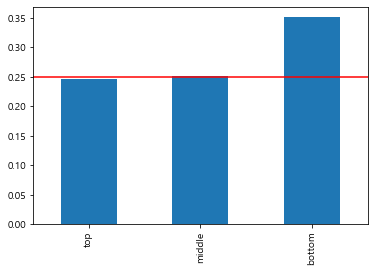

In [153]:
nowon_change_index['consume_ratio_AMT'].plot(kind='bar')
plt.axhline(0.249217, color='r')

### bottom(민감) 지역의 카드 변화율이 가장 두드러짐

# top 지역 품목별 소비지수 변화율

In [158]:
consume_nowon_top_line = consume_nowon_top_front.pivot_table(index='MCT_CAT_NM', values = 'consume_ratio_AMT', aggfunc='mean')
consume_nowon_top_line.columns = ['consume_ratio_AMT_front']
consume_nowon_top_line['consume_ratio_AMT_back'] = consume_nowon_top_back.pivot_table(index='MCT_CAT_NM', values = 'consume_ratio_AMT', aggfunc='mean')['consume_ratio_AMT']

In [226]:
consume_nowon_top_line['consume_change'] = (consume_nowon_top_line['consume_ratio_AMT_back'] - consume_nowon_top_line['consume_ratio_AMT_front']) / consume_nowon_top_line['consume_ratio_AMT_front']

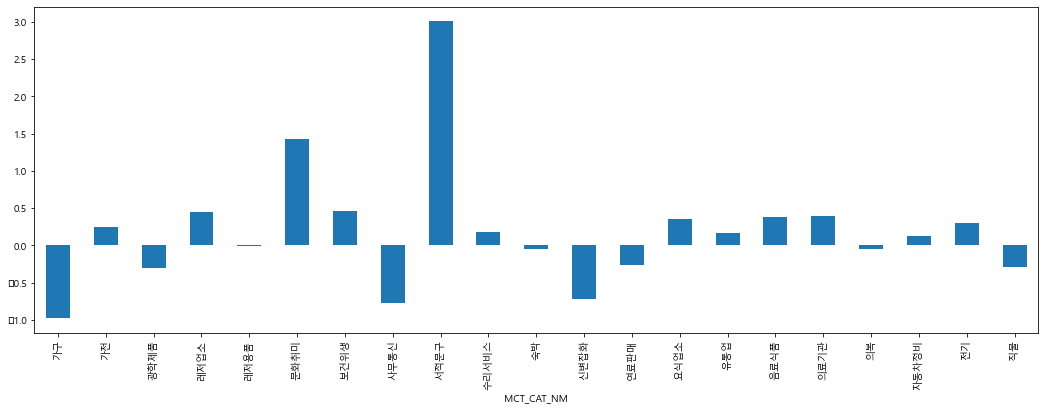

In [227]:
fig = plt.figure(figsize=(18, 6))
# consume_nowon_top_line.drop("가구",axis=0)['consume_change'].plot(kind='bar')
consume_nowon_top_line['consume_change'].plot(kind='bar')

# middle 지역 품목별 소비지수 변화율

In [229]:
consume_nowon_middle_line = consume_nowon_middle_front.pivot_table(index='MCT_CAT_NM', values = 'consume_ratio_AMT', aggfunc='mean')
consume_nowon_middle_line.columns = ['consume_ratio_AMT_front']
consume_nowon_middle_line['consume_ratio_AMT_back'] = consume_nowon_middle_back.pivot_table(index='MCT_CAT_NM', values = 'consume_ratio_AMT', aggfunc='mean')['consume_ratio_AMT']

In [230]:
consume_nowon_middle_line['consume_change'] = (consume_nowon_middle_line['consume_ratio_AMT_back'] - consume_nowon_middle_line['consume_ratio_AMT_front']) / consume_nowon_middle_line['consume_ratio_AMT_front']

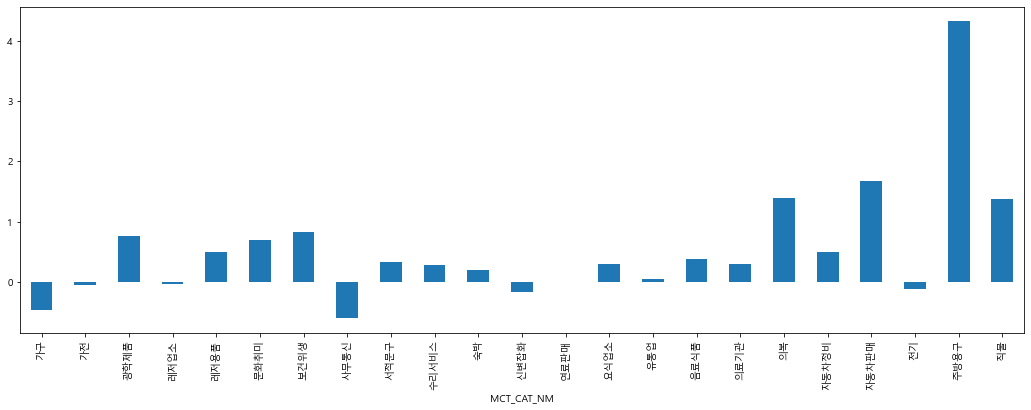

In [231]:
fig = plt.figure(figsize=(18, 6))
# consume_nowon_top_line.drop("가구",axis=0)['consume_change'].plot(kind='bar')
consume_nowon_middle_line['consume_change'].plot(kind='bar')

# bottom 지역 품목별 소비지수 변화율

In [232]:
consume_nowon_bottom_line = consume_nowon_bottom_front.pivot_table(index='MCT_CAT_NM', values = 'consume_ratio_AMT', aggfunc='mean')
consume_nowon_bottom_line.columns = ['consume_ratio_AMT_front']
consume_nowon_bottom_line['consume_ratio_AMT_back'] = consume_nowon_bottom_back.pivot_table(index='MCT_CAT_NM', values = 'consume_ratio_AMT', aggfunc='mean')['consume_ratio_AMT']

In [233]:
consume_nowon_bottom_line['consume_change'] = (consume_nowon_bottom_line['consume_ratio_AMT_back'] - consume_nowon_bottom_line['consume_ratio_AMT_front']) / consume_nowon_bottom_line['consume_ratio_AMT_front']

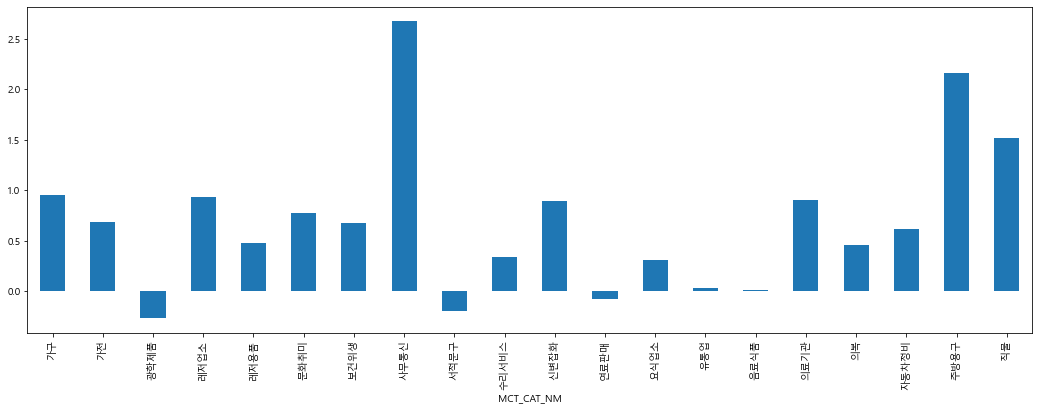

In [234]:
fig = plt.figure(figsize=(18, 6))
# consume_nowon_top_line.drop("가구",axis=0)['consume_change'].plot(kind='bar')
consume_nowon_bottom_line['consume_change'].plot(kind='bar')

# 전체 오버뷰

In [248]:
consume_nowon_top_line['district'] = 'top'
consume_nowon_middle_line['district'] = 'middle'
consume_nowon_bottom_line['district'] = 'bottom'

change_index = pd.concat([consume_nowon_top_line,consume_nowon_middle_line,consume_nowon_bottom_line])
change_index.reset_index(inplace=True)

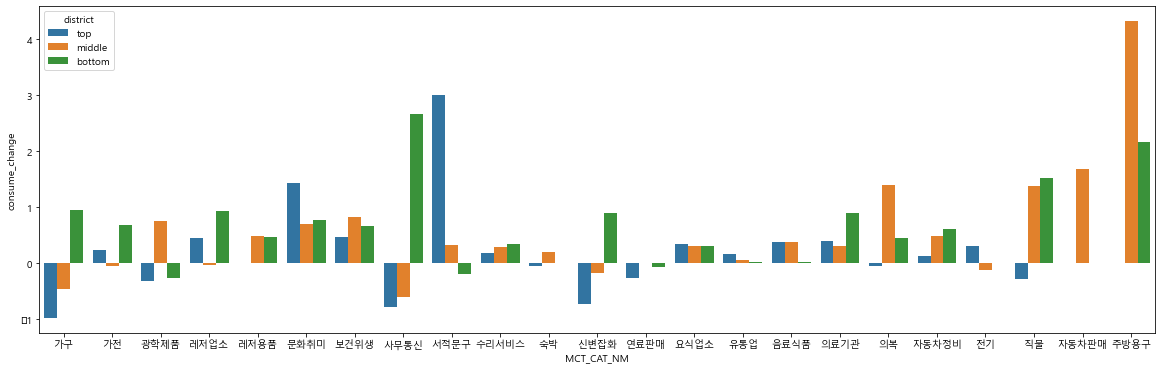

In [251]:
fig = plt.figure(figsize=(20, 6))

sns.barplot(x='MCT_CAT_NM', y = 'consume_change',hue='district', data = change_index)

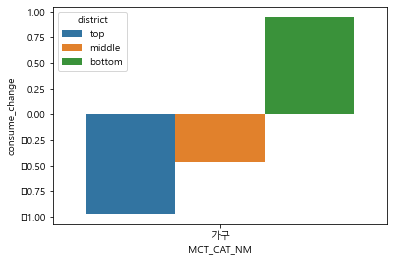

In [255]:
sns.barplot(x ='MCT_CAT_NM', y='consume_change', hue='district', data = change_index[change_index['MCT_CAT_NM'] == '가구'])

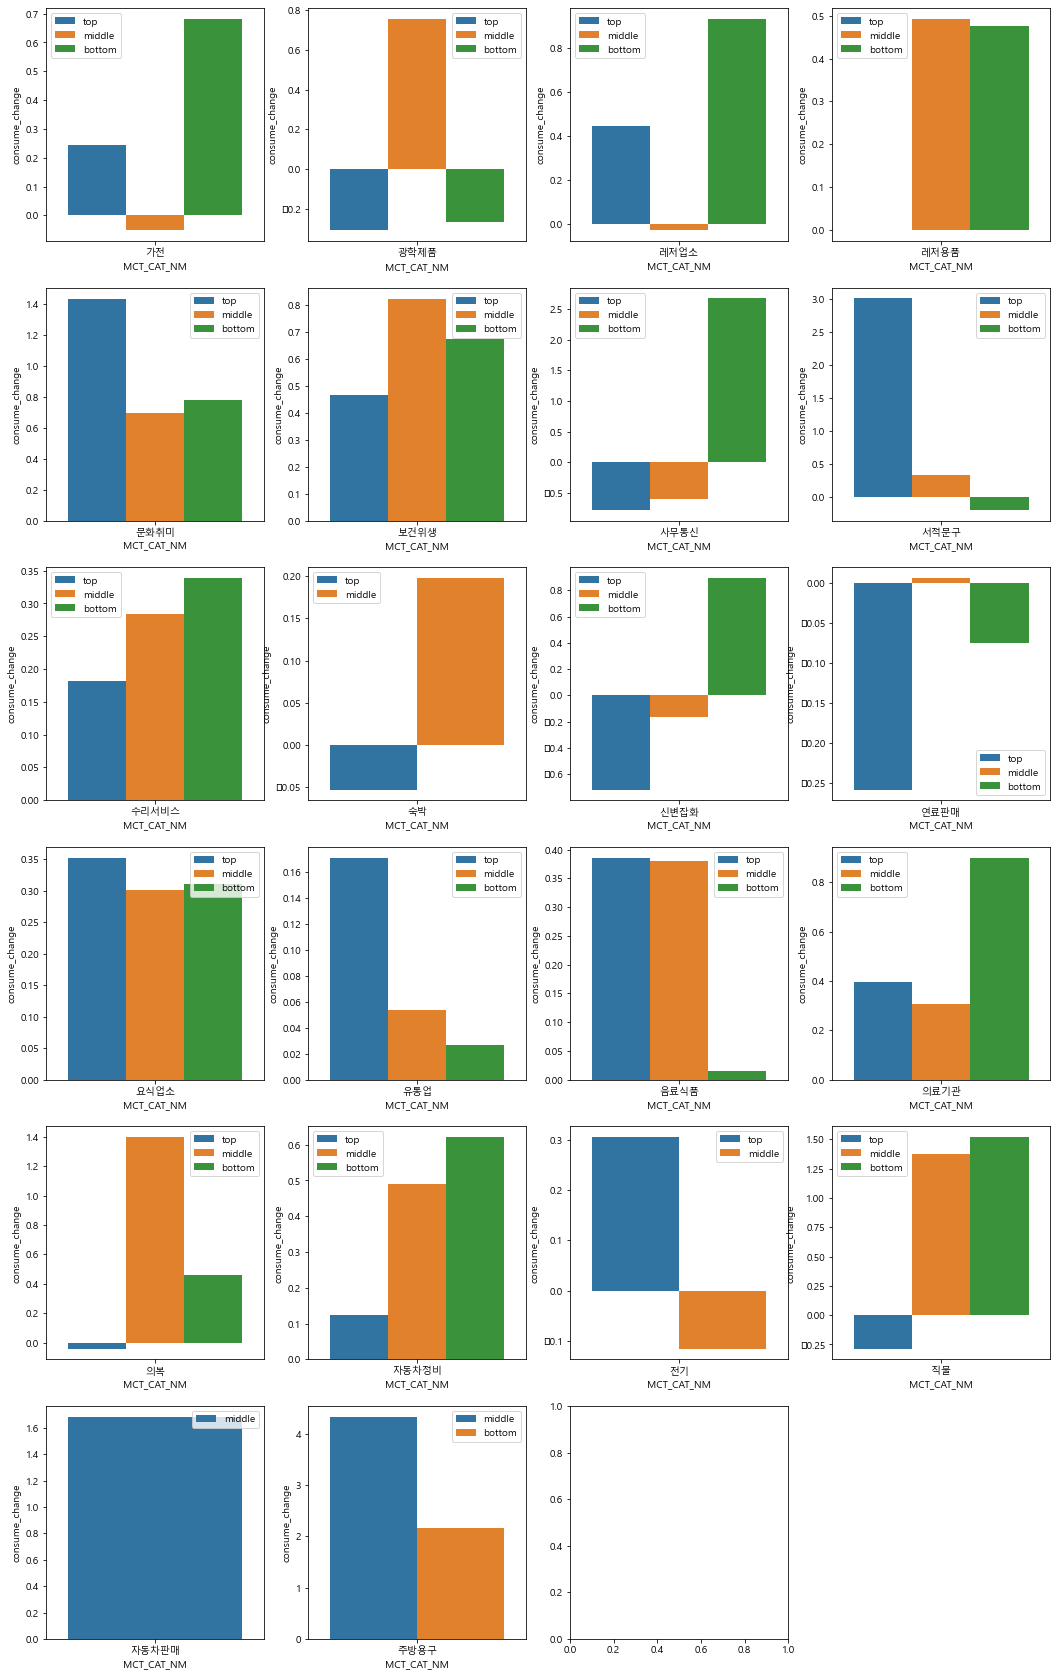

In [256]:
tmp_df = pd.DataFrame()
fig = plt.figure(figsize=(18, 30))
lines = change_index['MCT_CAT_NM'].unique()

for idx, line in enumerate(lines):
    tmp_df = change_index[change_index['MCT_CAT_NM'] == line]    
    sns.barplot(x ='MCT_CAT_NM', y='consume_change', hue='district', data = tmp_df)
    plt.legend()
    
    plt.subplot(6,4,idx+1)

# 이제 물류

In [260]:
cj_seoul.pivot_table(index=['week_num', 'DL_GD_LCLS_NM', 'CTGG_NM', 'HDNG_NM','year'], values='INVC_CONT', aggfunc='mean').reset_index()

,week_num,DL_GD_LCLS_NM,CTGG_NM,HDNG_NM,year,INVC_CONT
0,5,가구/인테리어,노원구,공릉1동,2019,71.400000
1,5,가구/인테리어,노원구,공릉1동,2020,81.142857
2,5,가구/인테리어,노원구,공릉2동,2019,79.200000
3,5,가구/인테리어,노원구,공릉2동,2020,85.714286
4,5,가구/인테리어,노원구,상계10동,2019,19.600000
...,...,...,...,...,...,...
11555,21,화장품/미용,중구,필동,2020,52.857143
11556,21,화장품/미용,중구,황학동,2019,130.000000
11557,21,화장품/미용,중구,황학동,2020,159.285714
11558,21,화장품/미용,중구,회현동,2019,163.666667
